In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dill as pickle

from common_setup import project_info, project_paths
import plotting_code

sk_dir = f"{project_paths.skeletons}/skeleton_files"
base_path = f"{project_paths.base}/pipelines"
height_bounds = np.load(f"{project_paths.data}/height_bounds_v1.npy")
width_bounds = np.load(f"{project_paths.data}/width_bounds_v1.npy")
layer_bounds = np.load(f"{project_paths.data}/layer_bounds_v3.npy")

feature_dir = f"{project_paths.data}/features/features_feb7"

height_bounds = height_bounds - height_bounds[0]

In [2]:
version = 795
data_dir = f'paper_versions/v{version}/data'
plot_dir = f'paper_versions/v{version}/plots'
plot_data_dir = f"{plot_dir}/associated_data"

ct_df = pd.read_pickle(f'{data_dir}/hlabel_types.pkl')
ct_df = ct_df.reset_index(drop=True)
dfct_e = pd.read_feather(f'{data_dir}/dfct_e.feather')

In [3]:
with open(f"{data_dir}/ctype_hues.pkl", "rb") as f:
    ctype_hues = pickle.load(f)

In [4]:
import feature_clustering as fc
import tqdm
from affine_transform import minnie_column_transform_nm, minnie_column_transform
tform_nm = minnie_column_transform_nm()
tform = minnie_column_transform()
from numbers import Number
from matplotlib import colors

clr = [0.3, 0.9, 0.8]


def path_line(path, sk, x_ind=0, y_ind=1, rescale=1):
    xs = sk.vertices[path, x_ind].squeeze()
    ys = sk.vertices[path, y_ind].squeeze()
    return xs / rescale, ys / rescale


def all_paths(sk, x_ind=0, y_ind=1, rescale=1):
    all_xs = []
    all_ys = []
    for path in sk.cover_paths_with_parent():
        xs, ys = path_line(path, sk, x_ind=x_ind, y_ind=y_ind, rescale=rescale)
        all_xs.append(np.atleast_1d(xs))
        all_xs.append(np.array([np.nan]))
        all_ys.append(np.atleast_1d(ys))
        all_ys.append(np.array([np.nan]))
    return np.concatenate(all_xs), np.concatenate(all_ys)


def darken_color(clr, delta=0.3):
    clr_hsv = colors.rgb_to_hsv(clr)
    vdiff = clr_hsv[2]
    return colors.hsv_to_rgb([x - delta * y for x, y in zip(clr_hsv, [0, 0, vdiff])])


def lighten_color(clr, delta=0.3):
    clr_hsv = colors.rgb_to_hsv(clr)
    vdiff = 1 - clr_hsv[2]
    return colors.hsv_to_rgb([x + delta * y for x, y in zip(clr_hsv, [0, 0, vdiff])])

def sample_width(
    root_id,
    x_offset=0,
    rescale=1000,
    dendrite_only=True,
    axon_anno=None,
    dendrite_anno=None,
    min_x=None,
    transform=None,
):
    if isinstance(root_id, Number):
        nrn = fc.io_utils.load_root_id(root_id, project_paths)
    else:
        nrn = root_id
    
    if transform:
        nrn.skeleton.vertices = transform.apply(nrn.skeleton.vertices)

    soma_pt = np.atleast_2d(nrn.skeleton.vertices[nrn.skeleton.root]) / rescale
    soma_pt_x = soma_pt[0, 0]

    if axon_anno is not None:
        is_axon = nrn.anno[axon_anno].mesh_mask
    else:
        is_axon = ~nrn.anno[dendrite_anno].mesh_mask
        
    with nrn.mask_context(~is_axon) as nrnf:
        x_dend, y_dend = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = x_dend[~np.isnan(x_dend)]

    if not dendrite_only:
        with nrn.mask_context(is_axon) as nrnf:
            x_axon, y_axon = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = np.concatenate((x_axon[~np.isnan(x_axon)], all_x))
        
    if min_x is not None:
        if np.min(all_x - soma_pt_x) + x_offset < min_x:
            x_offset = min_x + np.abs(np.min(all_x - soma_pt_x)) - soma_pt_x
    else:
        x_offset = x_offset - soma_pt_x

    return max(all_x+x_offset)

def plot_neuron(
    root_id,
    color,
    x_offset=0,
    ax=None,
    dendrite_only=True,
    axon_color=None,
    rescale=1000,
    axon_anno=None,
    dendrite_anno=None,
    axon_kwargs={},
    dendrite_kwargs={},
    soma_kwargs={},
    min_x=None,
    return_extent=False,
    transform=None
):
    if isinstance(root_id, Number):
        nrn = fc.io_utils.load_root_id(root_id, project_paths)
    else:
        nrn = root_id
    
    if transform:
        nrn.skeleton.vertices = transform.apply(nrn.skeleton.vertices)
        
    soma_pt = np.atleast_2d(nrn.skeleton.vertices[nrn.skeleton.root]) / rescale
    soma_pt_x = soma_pt[0, 0]
    
    if axon_anno is not None:
        is_axon = nrn.anno[axon_anno].mesh_mask
    else:
        is_axon = ~nrn.anno[dendrite_anno].mesh_mask
        
    with nrn.mask_context(~is_axon) as nrnf:
        x_dend, y_dend = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = x_dend[~np.isnan(x_dend)]

    if not dendrite_only:
        with nrn.mask_context(is_axon) as nrnf:
            x_axon, y_axon = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = np.concatenate((x_axon[~np.isnan(x_axon)], all_x))
        
    if min_x is not None:
        if np.min(all_x - soma_pt_x) + x_offset < min_x:
            x_offset = min_x + np.abs(np.min(all_x - soma_pt_x)) - soma_pt_x
    else:
        x_offset = x_offset - soma_pt_x

    if ax is None:
        ax = plt.gca()

    if axon_color is None:
        axon_color = lighten_color(color)

    if not dendrite_only:
        ax.plot(x_axon + x_offset, y_axon, color=axon_color, **axon_kwargs)
    ax.plot(x_dend + x_offset, y_dend, color=color, **dendrite_kwargs)

    ax.scatter(
        soma_pt[:, 0] + x_offset,
        soma_pt[:, 1],
        color=color,
        **soma_kwargs,
    )
    if ax.get_ylim()[0] < ax.get_ylim()[1]:
        ax.invert_yaxis()

    if return_extent:
        return min(all_x+x_offset), max(all_x+x_offset)
    
def plot_cell_lineup(
    df,
    ax,
    root_id,
    hue,
    palette,
    offset=300,
    spacing="tight",
    spacing_gap=0,
    dendrite_only=False,
    axon_anno=None,
    dendrite_anno=None,
    axon_kwargs=None,
    dendrite_kwargs=None,
    soma_kwargs=None,
    layer_bounds=None,
    height_bounds=None,
    transform=None,
    max_width=None,
):
    if axon_kwargs is None:
        axon_kwargs = {"linewidth": 0.5}
    if dendrite_kwargs is None:
        dendrite_kwargs = {"linewidth": 1}
    if soma_kwargs is None:
        soma_kwargs = {
            "s": 18,
            "edgecolors": (1, 1, 1),
            "linewidths": 0.75,
            "zorder": 20,
        }

    xmax = 0
    for ii, (_, row) in enumerate(df.iterrows()):
        
        if spacing == "tight":
            min_x = xmax + spacing_gap
            x_offset = xmax + spacing_gap
        elif spacing == "uniform":
            min_x = None
            x_offset = ii * offset
        else:
            raise ValueError('Spacing must be "tight" or "uniform"')
            
        if dendrite_only:
            dendrite_color=palette[row[hue]]
        else:
            dendrite_color=darken_color(palette[row[hue]])
        try:
            if row[hue] == "PTC":
                del_color = 0.5
            else:
                del_color = 0.3
        except:
            del_color = 0.3
            
        if transform is None:
            rescale = 1000
        else:
            rescale = 1
            
        if max_width is not None:
            new_max = sample_width(
                row[root_id],
                x_offset=x_offset,
                transform=transform,
                axon_anno=axon_anno,
                dendrite_anno=dendrite_anno,
                dendrite_only=dendrite_only,
                rescale=rescale,
            )
            if new_max > max_width:
                ax.set_aspect("equal")
                if layer_bounds is not None and len(df)>0:
                    plotting_code.plot_layers(
                        layer_bounds,
                        depth_bounds=height_bounds,
                        span=(first_min-10, max_width),
                        ax=ax,
                        linestyle="--",
                        color=(0.5, 0.5, 0.5),
                        alpha=0.5,
                        linewidth=1,
                    )
                return df.iloc[ii:]
            
        xmin, xmax = plot_neuron(
            row[root_id],
            ax=ax,
            x_offset=x_offset,
            color=dendrite_color,
            dendrite_only=dendrite_only,
            axon_anno=axon_anno,
            dendrite_anno=dendrite_anno,
            axon_color=lighten_color(palette[row[hue]], delta=del_color),
            axon_kwargs=axon_kwargs,
            dendrite_kwargs=dendrite_kwargs,
            soma_kwargs=soma_kwargs,
            min_x=min_x,
            return_extent=True,
            transform=transform,
            rescale=rescale,
        )
        
        if ii == 0:
            first_min = xmin
    
    ax.set_aspect("equal")
    if layer_bounds is not None and len(df)>0:
        if max_width is not None:
            span_max = max_width
        else:
            span_max = xmax+10
        plotting_code.plot_layers(
            layer_bounds,
            depth_bounds=height_bounds,
            span=(first_min-10, span_max),
            ax=ax,
            linestyle="--",
            color=(0.5, 0.5, 0.5),
            alpha=0.5,
            linewidth=1,
        )

In [6]:
ct_df['soma_depth'] = tform.apply_project('y', ct_df['pt_position'])

In [7]:
i_types = ["PTC", "DTC", "STC", "ITC"]

In [8]:
inh_df = ct_df.query('classification_system == "aibs_coarse_inhibitory"')

In [9]:
axon_length = []
dend_length = []
for oid in inh_df['pt_root_id']:
    nrn = fc.io_utils.load_root_id(oid, project_paths=project_paths)
    with nrn.mask_context( nrn.anno.is_axon.mesh_mask) :
        axon_length.append(nrn.path_length())
    with nrn.mask_context(~nrn.anno.is_axon.mesh_mask) :
        dend_length.append(nrn.path_length())

In [10]:
net_out_df = []
for oid in inh_df['pt_root_id']:
    nrn = fc.io_utils.load_root_id(oid, project_paths=project_paths)
    net_out_df.append( nrn.anno.pre_syn.df)

In [11]:
conn_df = pd.concat(net_out_df, ignore_index=True)

In [12]:
syn_per_conn_df = (
conn_df.groupby([
    'pre_pt_root_id',
    'post_pt_root_id',
]).count()[['id']].reset_index()
    .rename(columns={'id': 'num_syn'})
    .merge(
    ct_df[['pt_root_id', 'cell_type']].rename(columns={'cell_type': 'cell_type_post'}),
    left_on='post_pt_root_id',
    right_on='pt_root_id',
).drop(columns='pt_root_id').merge(
    inh_df[['pt_root_id', 'cell_type']].rename(columns={'cell_type': 'cell_type_pre'}),
    left_on='pre_pt_root_id',
    right_on='pt_root_id',
).drop(columns='pt_root_id')
)

In [13]:
ct_list_inh = ['PTC', 'DTC', 'STC', 'ITC']

In [14]:
ct_ord = ['L2a' ,'L2b', 'L2c', 'L3a', 'L3b', 'L4a', 'L4b', 'L4c',
          'L5a', 'L5b', "L5ET", "L5NP", 'L6short-a', 'L6short-b',
          'L6tall-a', 'L6tall-b', 'L6tall-c', 'L6wm',
         ] + ct_list_inh

In [15]:
syn_per_conn_df['cell_type_post'] = (
    syn_per_conn_df['cell_type_post'].astype(
        pd.CategoricalDtype(ct_ord, ordered=True)
    )
)

In [16]:
net_syn_out = []
for oid in inh_df['pt_root_id']:
    nrn = fc.io_utils.load_root_id(oid, project_paths=project_paths)
    net_syn_out.append( len(nrn.anno.pre_syn.df) )

In [17]:
save_figs = False

In [11]:
ct = 'PTC'
use_df = inh_df.query('cell_type==@ct').sort_values(by='soma_depth').copy()

ii = 0
while use_df is not None:
    fig, ax = plt.subplots( figsize=(15, 3), facecolor='w', dpi=300)
    use_df = plot_cell_lineup(
        use_df,
        ax=ax,
        root_id='pt_root_id',
        hue='cell_type',
        palette=ctype_hues,
        axon_anno='is_axon',
        dendrite_only=False,
        layer_bounds=layer_bounds,
        height_bounds=height_bounds,
        spacing_gap=10,
        transform=tform_nm,
        max_width=5000,
    )

    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_ylim(*height_bounds[::-1])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    plt.tight_layout()
    fig.savefig(f"{plot_dir}/interneurons_all_{ct}_row_{ii}.pdf")
    plt.close(fig)
    ii += 1
    if use_df is not None:
        print(f"Finished round {ii} | {len(use_df)} remaining...")
    else:
        print("Finished!")

Finished round 1 | 48 remaining...
Finished round 2 | 38 remaining...
Finished round 3 | 25 remaining...
Finished round 4 | 15 remaining...
Finished round 5 | 7 remaining...
Finished!


In [ ]:
for ct in i_types:

    simp_df = ct_df.query('cell_type == @ct')
    fig, ax = plt.subplots(figsize=(4*len(simp_df), 4), dpi=100)

    plot_cell_lineup(
        simp_df.sort_values(by='soma_depth'),
        ax=ax,
        root_id="pt_root_id",
        hue='cell_type',
        axon_anno='is_axon',
        palette=ctype_hues,
        layer_bounds=layer_bounds,
        height_bounds=height_bounds,
        spacing_gap=10,
        transform=tform_nm,
    )
    ax.set_ylim(*height_bounds[::-1])
    fig.savefig(f"{plot_dir}/interneurons_all_{ct}.pdf", bbox_inches="tight")
    plt.close(fig)

In [ ]:
for ct in i_types:
    if ct in ["PTC", "ITC", "STC"]:
        continue
    simp_df = ct_df.query('cell_type == @ct')
    fig, ax = plt.subplots(figsize=(4*5, 4), dpi=100)

    plot_cell_lineup(
        simp_df.sample(5).sort_values(by='soma_depth'),
        ax=ax,
        root_id="pt_root_id",
        hue='cell_type',
        axon_anno='is_axon',
        palette=ctype_hues,
        layer_bounds=layer_bounds,
        height_bounds=height_bounds,
        spacing_gap=10,
        transform=tform_nm,
    )
    ax.set_ylim(*height_bounds[::-1])
    sns.despine(ax=ax)
    fig.savefig(f"{plot_dir}/interneurons_sample_{ct}.pdf", bbox_inches="tight")
    plt.close(fig)

In [18]:
soma_df = pd.read_pickle('hlabel_types.pkl')
soma_df['soma_x'] = tform.apply_project('x', soma_df['pt_position'])
soma_df['soma_y'] = tform.apply_project('y', soma_df['pt_position'])
soma_df['soma_z'] = tform.apply_project('z', soma_df['pt_position'])

In [19]:
ct_list_exc = dfct_e["hlabel"].dtype.categories

syn_i_df = pd.read_feather(f"{data_dir}/syn_i_df.feather")
syn_i_df = syn_i_df.merge(
    soma_df[["pt_root_id", "cell_type"]].rename(
        columns={"cell_type": "cell_type_post"}
    ),
    left_on="post_pt_root_id",
    right_on="pt_root_id",
)
syn_i_df["cell_type_post"] = syn_i_df["cell_type_post"].astype(
    pd.CategoricalDtype(list(ct_list_exc) + ["PTC", "DTC", "ITC", "STC"], ordered=True)
)

syn_i_df = syn_i_df.drop(columns="cell_type_pre").merge(
    soma_df[["pt_root_id", "cell_type"]].rename(
        columns={"pt_root_id": "pre_pt_root_id", "cell_type": "cell_type_pre"}
    ),
    on="pre_pt_root_id",
)

In [20]:
syn_ie_df = syn_i_df.query('cell_type_post in @ct_list_exc')
syn_ie_df['cell_type_post'] = syn_ie_df['cell_type_post'].astype(pd.CategoricalDtype(ct_list_exc, ordered=True))

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/301312977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_ie_df['cell_type_post'] = syn_ie_df['cell_type_post'].astype(pd.CategoricalDtype(ct_list_exc, ordered=True))


In [21]:
df = pd.DataFrame(
    {
        'num_syn_tot': syn_ie_df.groupby(['cell_type_post']).count()['id'].rename('num_syn_tot'),
        'num_cells': dfct_e.groupby('hlabel').count()['root_id'].rename('num_cells'),
    }
)

df['syn_per_cell'] = df['num_syn_tot'] / df['num_cells']
df = df.loc[ct_list_exc]

In [22]:
syn_i_df['syn_on_target'] = syn_i_df.groupby('post_pt_root_id')['id'].transform('count')
syn_ie_df['syn_on_target'] = syn_ie_df.groupby('post_pt_root_id')['id'].transform('count')

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/1354704496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_ie_df['syn_on_target'] = syn_ie_df.groupby('post_pt_root_id')['id'].transform('count')


In [24]:
syn_per_class = syn_i_df.groupby(["post_pt_root_id"]).count()[
    "id"
].reset_index().merge(
    ct_df[["pt_root_id", "cell_type"]], left_on="post_pt_root_id", right_on="pt_root_id"
).query(
    "cell_type not in @i_types"
)

syn_per_class['cell_type'] = syn_per_class['cell_type'].astype(pd.CategoricalDtype(ct_list_exc, ordered=True))

In [26]:
syn_per_class = syn_i_df.groupby(["cell_type_pre", "post_pt_root_id"]).count()[
    "id"
].reset_index().merge(
    ct_df[["pt_root_id", "cell_type"]], left_on="post_pt_root_id", right_on="pt_root_id"
).query(
    "cell_type not in @i_types"
)

syn_per_class['cell_type'] = syn_per_class['cell_type'].astype(pd.CategoricalDtype(ct_list_exc, ordered=True))

In [28]:
spc_df = syn_per_class.pivot_table(
    values="id",
    index=["cell_type", "pt_root_id"],
    columns="cell_type_pre",
    fill_value=0,
).reset_index()

In [29]:
from scipy import stats

In [30]:
spc_df['DTCz'] = spc_df.groupby('cell_type').transform(stats.zscore)['DTC']
spc_df['PTCz'] = spc_df.groupby('cell_type').transform(stats.zscore)['PTC']

In [31]:
spearman_func = lambda x, y: stats.pearsonr(x, y)[0]

sp_corr = []
sp_corr_p = []
sp_corr_low = []
sp_corr_high = []

for ct in ct_list_exc:
    
    res = stats.bootstrap(
        spc_df.query('cell_type==@ct')[['PTC', 'DTC']].values.T,
        spearman_func,
        n_resamples=2000,
        paired=True,
    )

    conf_int = list(res.confidence_interval)
    val, pv = stats.pearsonr(
        spc_df.query('cell_type==@ct')["PTC"], spc_df.query('cell_type==@ct')["DTC"]
    )
    sp_corr.append(val)
    sp_corr_p.append(pv)
    sp_corr_low.append(conf_int[0])
    sp_corr_high.append(conf_int[1])

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/4265298705.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_func = lambda x, y: stats.pearsonr(x, y)[0]


In [32]:
import statsmodels.api as sm

In [33]:
spearman_df = pd.DataFrame(
    {
        'cell_type': ct_list_exc,
        'corr': sp_corr,
        'corr_p': sp_corr_p,
        'corr_lb': sp_corr_low,
        'corr_ub': sp_corr_high,
    }
)

spearman_df['corr_p_adj'] = sm.stats.multipletests(spearman_df['corr_p'], method='hs')[1]
spearman_df['sig_adj'] = sm.stats.multipletests(spearman_df['corr_p'], method='hs')[0]

In [ ]:
spearman_df.to_csv(f"{plot_dir}/associated_data/correlation_ptc_dtc.csv")

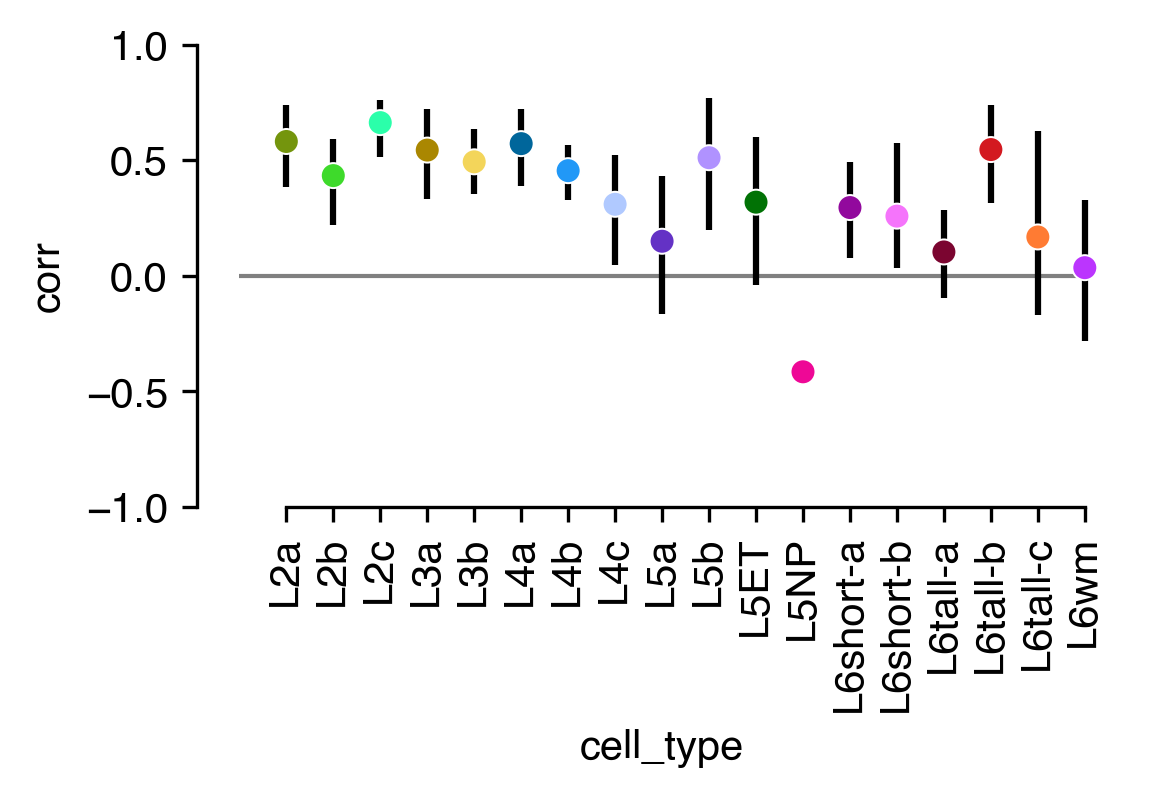

In [37]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)

eb = np.vstack(
    (
        spearman_df["corr"] - spearman_df["corr_lb"],
        spearman_df["corr_ub"] - spearman_df["corr"],
    )
)
ax.errorbar(
    spearman_df.index,
    spearman_df["corr"],
    eb,
    zorder=10,
    fmt='none',
    color='k',
)
sns.scatterplot(
    x='cell_type',
    y='corr',
    hue='cell_type',
    palette=ctype_hues,
    data=spearman_df,
    zorder=20,
    legend=False,
)
ax.hlines(0,-1,17, color=(0.5, 0.5, 0.5), linewidth=1, linestyle='-', zorder=-10)
ax.set_ylim(-1,1)
sns.despine(ax=ax, trim=True)
_  = plt.xticks(rotation=90)
fig.savefig(f"{plot_dir}/correlation_ptc_dtc_ct.pdf")

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/1826754076.py:16: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/1826754076.py:16: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


ValueError: Unrecognized linestyle: {'width': 1}

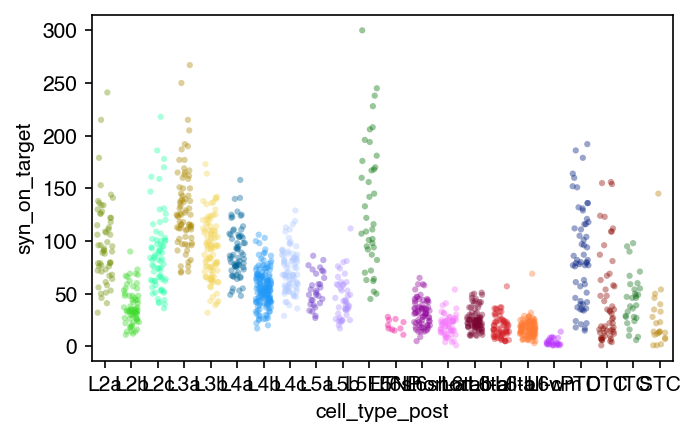

In [38]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

sns.stripplot(
    x="cell_type_post",
    y="syn_on_target",
    data=syn_i_df.drop_duplicates("post_pt_root_id"),
    hue="cell_type_post",
    palette=ctype_hues,
    ax=ax,
    alpha=0.4,
    jitter=0.3,
    size=3,
    zorder=-10,
)

sns.pointplot(
    x="cell_type_post",
    y="syn_on_target",
    data=syn_i_df.drop_duplicates("post_pt_root_id"),
    color="k",
    ax=ax,
    join=False,
    linestyles={"width": 1},
    scale=0.65,
    # zorder=10,
    estimator=np.median,
)

ax.legend().set_visible(False)
ax.xaxis.set_tick_params(rotation=90)
ax.grid(axis="y", linestyle=":", color=(0.5, 0.5, 0.5), alpha=0.5, zorder=-20)
sns.despine(ax=ax, offset=1)

ax.set_ylabel("# Syn/cell (in column)")
ax.set_xlabel(None)
if save_figs:
    fig.savefig(f"{plot_dir}/interneuron_synapses_within_data.pdf", bbox_inches="tight")

In [39]:
def _compartment(row):
    if row['is_soma']:
        return 'soma'
    elif row['is_proximal']:
        return 'prox'
    elif row['is_dendrite'] and not row['is_apical']:
        return 'dist'
    elif row['is_dendrite'] and row['is_apical']:
        return 'apic'
    else:
        return 'other'

syn_ie_df['compartment'] = syn_ie_df.apply(_compartment, axis=1)

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/3959575716.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_ie_df['compartment'] = syn_ie_df.apply(_compartment, axis=1)


In [40]:
soma_count = dfct_e.groupby('hlabel').count()[['root_id']].rename(columns={'root_id': 'num_soma'})

In [41]:
syn_ie_df['syn_in_conn'] = syn_ie_df.groupby(["pre_pt_root_id", "post_pt_root_id"])['id'].transform('count')

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/3294809964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_ie_df['syn_in_conn'] = syn_ie_df.groupby(["pre_pt_root_id", "post_pt_root_id"])['id'].transform('count')


In [42]:
layer_locs = [3, 5, 8, 12, 14, 17]

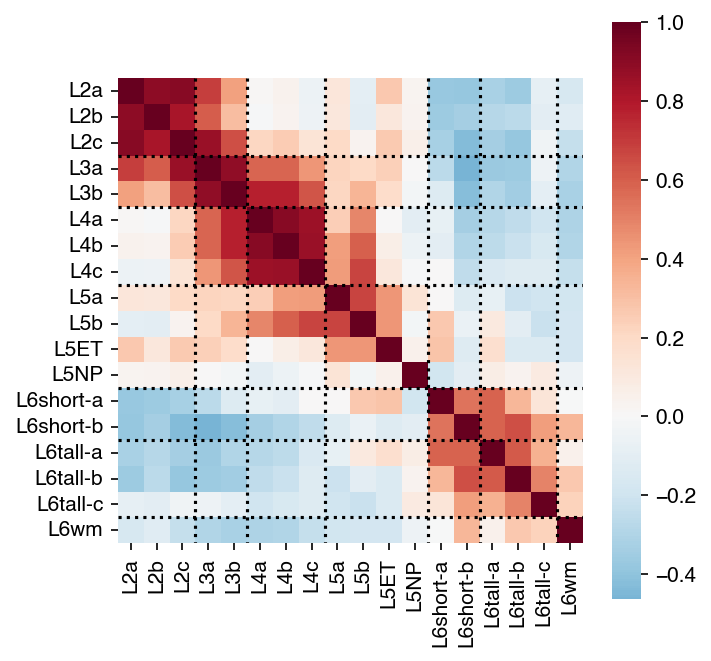

In [43]:
keep_i_types = ["DTC", "PTC"]

density_df = pd.DataFrame(
    index=syn_i_df.query("cell_type_pre in @keep_i_types")["pre_pt_root_id"].unique()
)
for ct in ct_list_exc:
    density_df[ct] = (
        syn_ie_df.query("cell_type_pre in @keep_i_types")
        .query("syn_in_conn >= 2")
        .drop_duplicates(subset=["pre_pt_root_id", "post_pt_root_id"])
        .query('cell_type_post == @ct and compartment != "other"')
        .groupby(["pre_pt_root_id"])
        .count()
        .reset_index()
        .pivot_table(values="id", index="pre_pt_root_id", aggfunc="sum", fill_value=0)
        .rename(columns={"id": ct})
        / soma_count.loc[ct]["num_soma"]
    )[ct]
density_df.fillna(0, inplace=True)

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
sns.heatmap(density_df.corr(method="spearman"), center=0, cmap="RdBu_r", ax=ax)
ax.set_aspect("equal")
density_df_all = density_df.copy()
ax.vlines(layer_locs, 0, len(ct_list_exc), color="k", linestyle=":")
ax.hlines(layer_locs, 0, len(ct_list_exc), color="k", linestyle=":")

# plt.savefig(f'{plot_dir}/density_correlation_all.pdf', bbox_inches='tight')
# density_df.corr(method='pearson').to_csv(f"{plot_data_dir}/density_correlation_all.csv")

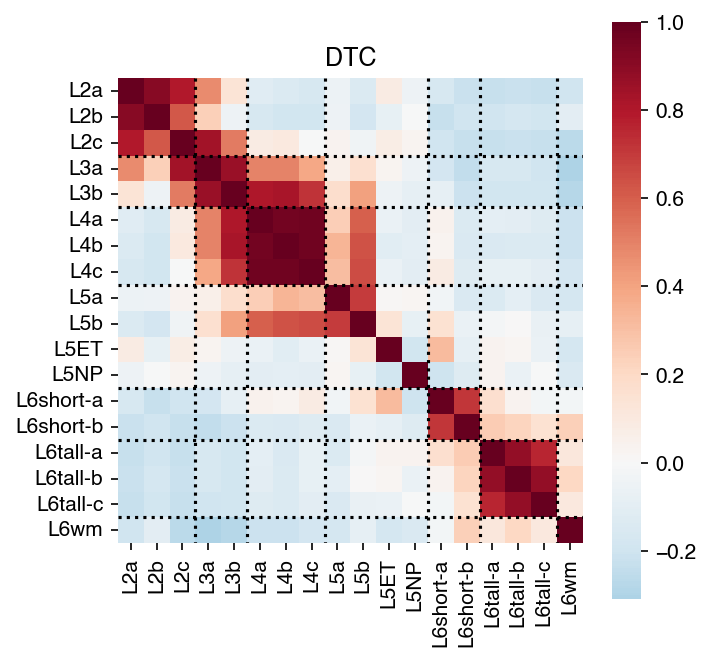

In [44]:
keep_i_types = ["DTC"]

density_df = pd.DataFrame(
    index=syn_i_df.query("cell_type_pre in @keep_i_types")["pre_pt_root_id"].unique()
)
for ct in ct_list_exc:
    density_df[ct] = (
        syn_ie_df.query("cell_type_pre in @keep_i_types")
        .query("syn_in_conn >= 2")
        .drop_duplicates(subset=["pre_pt_root_id", "post_pt_root_id"])
        .query('cell_type_post == @ct and compartment != "other"')
        .groupby(["pre_pt_root_id"])
        .count()
        .reset_index()
        .pivot_table(values="id", index="pre_pt_root_id", aggfunc="sum", fill_value=0)
        .rename(columns={"id": ct})
        / soma_count.loc[ct]["num_soma"]
    )[ct]
density_df.fillna(0, inplace=True)

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
sns.heatmap(density_df.corr(method="pearson"), center=0, cmap="RdBu_r", ax=ax)
ax.vlines(layer_locs, 0,18, color='k', linestyle=':')
ax.hlines(layer_locs, 0,18, color='k', linestyle=':')
ax.set_title('DTC')
ax.set_aspect("equal")
density_df_dtc = density_df.copy()

# plt.savefig(f"{plot_dir}/density_correlation_dtc.pdf", bbox_inches="tight")
# density_df.corr(method="spearman").to_csv(f"{plot_data_dir}/density_correlation_dtc.csv")

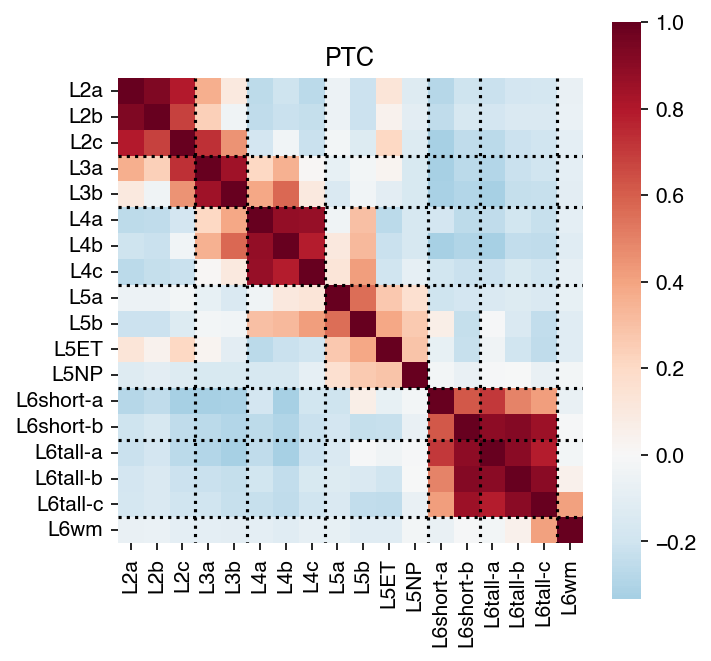

In [46]:
keep_i_types = ["PTC"]

density_df = pd.DataFrame(
    index=syn_i_df.query("cell_type_pre in @keep_i_types")["pre_pt_root_id"].unique()
)
for ct in ct_list_exc:
    density_df[ct] = (
        syn_ie_df.query("cell_type_pre in @keep_i_types")
        .query('syn_in_conn >= 2')
        .drop_duplicates(subset=["pre_pt_root_id", "post_pt_root_id"])
        .query('cell_type_post == @ct and compartment != "other"')
        .groupby(["pre_pt_root_id"])
        .count()
        .reset_index()
        .pivot_table(values="id", index="pre_pt_root_id", aggfunc="sum", fill_value=0)
        .rename(columns={"id": ct})
        / soma_count.loc[ct]["num_soma"]
    )[ct]
density_df.fillna(0, inplace=True)

fig, ax = plt.subplots(figsize=(5,5), dpi=150)
sns.heatmap(density_df.corr(method='pearson'), center=0, cmap='RdBu_r', ax=ax)
ax.vlines(layer_locs, 0,18, color='k', linestyle=':')
ax.hlines(layer_locs, 0,18, color='k', linestyle=':')
ax.set_title('PTC')

ax.set_aspect('equal')

density_df_ptc = density_df.copy()

# plt.savefig(f'{plot_dir}/density_correlation_ptc.pdf', bbox_inches='tight')
# density_df.corr(method='pearson').to_csv(f"{plot_data_dir}/density_correlation_ptc.csv")

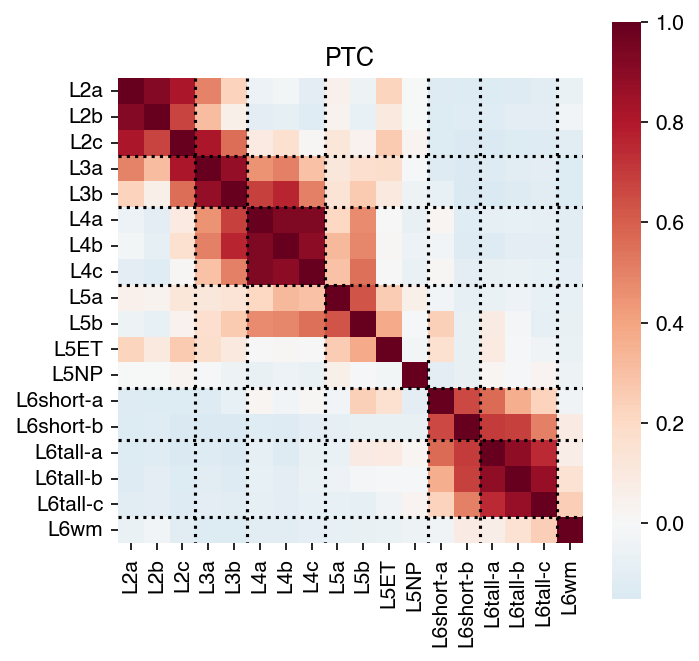

In [49]:
keep_i_types = ["PTC", "DTC", "STC", "ITC"]

density_df = pd.DataFrame(
    index=syn_i_df.query("cell_type_pre in @keep_i_types")["pre_pt_root_id"].unique()
)
for ct in ct_list_exc:
    density_df[ct] = (
        syn_ie_df.query("cell_type_pre in @keep_i_types")
        .query('syn_in_conn >= 2')
        .drop_duplicates(subset=["pre_pt_root_id", "post_pt_root_id"])
        .query('cell_type_post == @ct and compartment != "other"')
        .groupby(["pre_pt_root_id"])
        .count()
        .reset_index()
        .pivot_table(values="id", index="pre_pt_root_id", aggfunc="sum", fill_value=0)
        .rename(columns={"id": ct})
        / soma_count.loc[ct]["num_soma"]
    )[ct]
density_df.fillna(0, inplace=True)

fig, ax = plt.subplots(figsize=(5,5), dpi=150)
sns.heatmap(density_df.corr(method='pearson'), center=0, cmap='RdBu_r', ax=ax)
ax.vlines(layer_locs, 0,18, color='k', linestyle=':')
ax.hlines(layer_locs, 0,18, color='k', linestyle=':')
ax.set_title('PTC')

ax.set_aspect('equal')

density_df_all = density_df.copy()

# plt.savefig(f'{plot_dir}/density_correlation_ptc.pdf', bbox_inches='tight')
# density_df.corr(method='pearson').to_csv(f"{plot_data_dir}/density_correlation_ptc.csv")

In [ ]:
keep_i_types = ["ITC"]

ct = "L2b"
density_df = pd.DataFrame(
    index=syn_i_df.query("cell_type_pre in @keep_i_types")["pre_pt_root_id"].unique()
)
for ct in ct_list_exc:
    try:
        density_df[ct] = (
            syn_ie_df.query("cell_type_pre in @keep_i_types")
            .drop_duplicates(subset=["pre_pt_root_id", "post_pt_root_id"])
            .query('hlabel == @ct and compartment != "other"')
            .groupby(["pre_pt_root_id"])
            .count()
            .reset_index()
            .pivot_table(values="id", index="pre_pt_root_id", aggfunc="sum", fill_value=0)
            .rename(columns={"id": ct})
            / soma_count.loc[ct]["num_soma"]
        )[ct]
    except:
        continue
        
density_df.fillna(0, inplace=True)

fig, ax = plt.subplots(figsize=(5,5), dpi=150)
sns.heatmap(density_df.corr(method='pearson'), center=0, cmap='RdBu_r', ax=ax)
ax.set_aspect('equal')
# density_df_ptc = density_df.copy()

In [ ]:
from scipy import stats
stats.pearsonr(density_df_dtc.corr().values.ravel(), density_df_ptc.corr().values.ravel())

In [ ]:
dtc_corr = density_df_dtc.corr().values.ravel()
dtc_corr = dtc_corr[~np.isclose(dtc_corr, 1)]

ptc_corr = density_df_ptc.corr().values.ravel()
ptc_corr = ptc_corr[~np.isclose(ptc_corr,1)]

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(dtc_corr, ptc_corr, ax=ax, color='k')
ax.plot((-1,1), (-1,1), ':', color=(0.5, 0.5, 0.5), zorder=-10)
ax.set_xlim(-0.5, 1.05)
ax.set_ylim(-0.5, 1.05)
ax.set_aspect('equal')
ax.set_xlabel('DTC correlation')
ax.set_ylabel('PTC correlation')
sns.despine(ax=ax, offset=5)
ax.set_title(f'Pearson r: {stats.pearsonr(dtc_corr, ptc_corr)[0]: 0.2f}')
# plt.savefig('plots/ptc_dtc_correlation_correlation.pdf', bbox_inches='tight')

In [ ]:
density_df_aug = density_df_all.merge(
    ct_df[['pt_root_id', 'cell_type', 'soma_depth']],
    left_index=True,
    right_on='pt_root_id',
    how='left',
).set_index('pt_root_id')

density_df_aug['cell_type'] =  density_df_aug['cell_type'].astype(pd.CategoricalDtype(['PTC', 'DTC', 'STC'], ordered=True))

In [ ]:
sort_ord = density_df_aug[ct_list_exc].sum(axis=1).sort_values(ascending=False).index

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
sns.heatmap(
    density_df_aug.query('cell_type == "PTC"').sort_values(by=["soma_depth"])[ct_list_exc].T,
    vmin=0,
    vmax=1,
    cmap="RdYlBu_r",
    ax=ax,
    xticklabels=False,
    yticklabels=ct_list_exc,
    cbar=True,
)
ax.vlines(vlines, 0,19, 'w')
fig.savefig(f"{plot_dir}/density_plot_ptc.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
sns.heatmap(
    density_df_aug.query('cell_type == "DTC"').sort_values(by=["soma_depth"])[ct_list_exc].T,
    vmin=0,
    vmax=1,
    cmap="RdYlBu_r",
    ax=ax,
    xticklabels=False,
    yticklabels=ct_list_exc,
    cbar=True,
)
ax.vlines(vlines, 0,19, 'w')
fig.savefig(f"{plot_dir}/density_plot_all_dtc.pdf")

In [ ]:
g = sns.clustermap(
    density_df_all[np.invert(density_df_all.sum(axis=1)==0)],
    cmap="viridis",
    metric="correlation",
    method="average",
    col_cluster=True,
    figsize=(7, 12),
    vmin=0,
    vmax=1,
)
# g.ax_heatmap.set_yticks([])
# plt.savefig(f'{plot_dir}/density_clustermap_targ_ordered.pdf', bbox_inches='tight')

In [ ]:
density_df_all.max(axis=0).to_csv(f"{plot_data_dir}/density_all_max_by_type.csv")

In [ ]:
dtc_df = syn_ie_df.query('cell_type_pre == "DTC" and compartment in ["apic", "dist"]').groupby(
    ["pre_pt_root_id", "compartment"]
).count()["id"].rename("num_syn").reset_index().pivot_table(values='num_syn', index="pre_pt_root_id", columns='compartment')

dtc_df['total'] = dtc_df.sum(axis=1)

dtc_df['apic_prop'] = dtc_df['apic']/dtc_df['total']

dtc_df.sort_values(by='apic_prop').to_csv(f"{plot_data_dir}/density_apical_proportion.csv")

In [ ]:
ptc_df = syn_ie_df.query('cell_type_pre == "PTC" and compartment in ["soma", "prox"]').groupby(
    ["pre_pt_root_id", "compartment"]
).count()["id"].rename("num_syn").reset_index().pivot_table(values='num_syn', index="pre_pt_root_id", columns='compartment')

ptc_df['total'] = ptc_df.sum(axis=1)

ptc_df['soma_prop'] = ptc_df['soma']/ptc_df['total']

ptc_df.sort_values(by='soma_prop').to_csv(f"{plot_data_dir}/density_soma_proportion.csv")

In [ ]:
root_id = 864691135386843521

target_ct = "L2a"
target_oids = syn_ie_df.query('pre_pt_root_id == @root_id and cell_type_post==@target_ct')['post_pt_root_id'].unique()

fig, ax = plt.subplots(figsize=(5,5), dpi=150)
sns.scatterplot(
    x='soma_x',
    y='soma_z',
    data=soma_df.query('pt_root_id not in @target_oids and cell_type==@target_ct'),
    color=(0.7, 0.7, 0.7),
    size=40,
    legend=False,
)

sns.scatterplot(
    x='soma_x',
    y='soma_z',
    hue='cell_type',
    data=soma_df.query('pt_root_id in @target_oids'),
    palette=ctype_hues,
    size=60,
    legend=False,
    edgecolor='k',
    
)

In [ ]:
nrn = fc.io_utils.load_root_id(root_id, project_paths)

In [ ]:
with nrn.mask_context(nrn.anno.is_axon.mesh_mask) as nrnf:
    axon_verts = nrnf.skeleton.vertices / 1000

In [ ]:
# root_id = 864691135575445022

target_ct = "L2high"
target_oids = syn_ie_df.query("pre_pt_root_id == @root_id and cell_type_post==@target_ct")[
    "post_pt_root_id"
].unique()
print(len(target_oids))

In [ ]:
root_id = 864691135386843521

nrn = fc.io_utils.load_root_id(root_id, project_paths)
is_axon = nrn.anno.is_axon.mesh_mask
with nrn.mask_context(is_axon) as nrnf:
    x_axon, y_axon = all_paths(nrnf.skeleton, x_ind=0, y_ind=2, rescale=1000)

In [ ]:
target_ct = "L2b"
target_oids = syn_ie_df.query("pre_pt_root_id == @root_id and cell_type_post==@target_ct")[
    "post_pt_root_id"
].unique()

f'{target_ct}: {len(soma_df.query("pt_root_id in @target_oids"))} / {len(soma_df.query("cell_type == @target_ct"))}'

In [ ]:
target_ct = "L2a"
target_oids = syn_ie_df.query("pre_pt_root_id == @root_id and cell_type_post==@target_ct")[
    "post_pt_root_id"
].unique()

f'{target_ct}: {len(soma_df.query("pt_root_id in @target_oids"))} / {len(soma_df.query("cell_type == @target_ct"))}'

In [ ]:
len(soma_df.query("pt_root_id not in @target_oids and cell_type==@target_ct"))

In [ ]:
for target_ct in ["L2a", "L2b", "L3b", "L4b"]:
    target_oids = syn_ie_df.query("pre_pt_root_id == @root_id and cell_type_post==@target_ct")[
        "post_pt_root_id"
    ].unique()

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
    sns.scatterplot(
        x="soma_x",
        y="soma_z",
        data=soma_df.query("pt_root_id not in @target_oids and cell_type==@target_ct"),
        color=(0.5, 0.5, 0.5),
        s=15,
        legend=False,
        edgecolor="k",
    )

    sns.scatterplot(
        x="soma_x",
        y="soma_z",
        hue="cell_type",
        data=soma_df.query("pt_root_id in @target_oids"),
        palette=ctype_hues,
        s=20,
        legend=False,
        edgecolor="k",
    )
    ax.set_aspect("equal")
    ax.plot(
        x_axon,
        y_axon,
        color=(0.8, 0.8, 0.8),
        linewidth=1,
        zorder=-10,
        alpha=0.9,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Soma x')
    ax.set_ylabel('Soma z')
    sns.despine(ax=ax, offset=5, trim=True, left=True, bottom=True)

    ax.plot([550, 650], [720, 720], color='k', linewidth=5, solid_capstyle='butt')
    plt.savefig(f'{plot_dir}/connection_density_{root_id}_{target_ct}.pdf', bbox_inches='tight')

In [ ]:
i_types = ['DTC', 'PTC', 'STC', 'ITC']

In [ ]:
def load_table_df(root_id, project_paths, version):
    table_df = pd.read_feather(f"{project_paths.data}/specificity_data/slanted/v{version}/bin_count_{root_id}.feather")

    table_df['cell_type'] = table_df['cell_type_comp'].apply(lambda x: x.split('_')[0])
    ct_lookup = {
            "BC": "Inh",
            "MC": "Inh",
            "BPC": "Inh",
            "NGC": "Inh",
            "Unsure I": "Inh",
        }
    table_df['cell_type'] = table_df['cell_type'].apply(lambda x: ct_lookup.get(x,x))
    table_df['comp'] = table_df['cell_type_comp'].apply(lambda x: x.split('_')[1])

    iidx = table_df.query('cell_type in @i_types').index
    table_df.loc[iidx, 'comp'] = 'inh'
    table_df['frac_baseline'] = stats.zscore(np.log2(table_df['bin_total'] * table_df['num_syn_overall'] / table_df['bin_total_overall']+0.5))
    table_df['log_syn'] = stats.zscore(np.log2(table_df['num_syn']+1))
    
    return table_df

def aggregate_dfs(table_df, cell_types):
    if "Inh" not in cell_types:
        cell_types = cell_types + ["Inh"]
    inh_idx = table_df.query('comp == "inh"').index
    table_df = table_df.copy()
    table_df.loc[inh_idx, 'cell_type'] = "Inh"
    table_df.loc[inh_idx, 'comp'] = "basal"
    table_df['baseline_abundance'] = table_df['bin_total'] * table_df['p_overall']
    abundance_df = (
        table_df.groupby(["cell_type", "comp"])
        .agg({"baseline_abundance": "sum", "num_syn": "sum", "num_syn_overall": "sum"})
        .reset_index()
    )
    
    abundance_df['cell_type'] = abundance_df['cell_type'].astype(pd.CategoricalDtype(cell_types, ordered=True))
    abundance_df['comp'] = abundance_df['comp'].astype(pd.CategoricalDtype(["soma", "prox", "basal", "apical"], ordered=True))
    
    return abundance_df.dropna().reset_index(drop=True)

In [ ]:
import tqdm
from scipy.spatial import distance

In [ ]:
ct_types = ['Inh'] + ct_list_exc

In [ ]:
i_oids = np.load(f'{data_dir}/i_oids_v{version}.npy')

---

In [57]:
ct_list_exc = list(ct_list_exc)

In [58]:
i_types = ['PTC', 'DTC', 'STC', 'ITC']

In [59]:
syn_i_df_ct = syn_i_df.copy()
soma_i_df = soma_df.query('classification_system == "aibs_coarse_inhibitory"')

In [60]:
soma_i_df['cell_type'] = soma_i_df['cell_type'].astype(pd.CategoricalDtype(i_types, ordered=True))

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/2220518239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soma_i_df['cell_type'] = soma_i_df['cell_type'].astype(pd.CategoricalDtype(i_types, ordered=True))


In [61]:
iall_edgelist = (
    syn_i_df.groupby(
        ["pre_pt_root_id", "cell_type_pre", "post_pt_root_id", "cell_type_post"]
    )
    .count()["id"]
    .reset_index()
    .rename(columns={"id": "num_syn"})
)
iall_edgelist = iall_edgelist.query("num_syn>0").reset_index()
iall_edgelist = iall_edgelist.merge(
    soma_df[["pt_root_id", "soma_y"]].rename(columns={"soma_y": "pre_soma_y"}),
    left_on="pre_pt_root_id",
    right_on="pt_root_id",
    how="left",
).drop(columns="pt_root_id")
iall_edgelist = iall_edgelist.merge(
    soma_df[["pt_root_id", "soma_y"]].rename(columns={"soma_y": "post_soma_y"}),
    left_on="post_pt_root_id",
    right_on="pt_root_id",
    how="left",
).drop(columns="pt_root_id")

iall_edgelist["cell_type_pre"] = iall_edgelist["cell_type_pre"].astype(
    pd.CategoricalDtype(list(ct_list_exc) + i_types, ordered=True)
)
iall_edgelist["cell_type_post"] = iall_edgelist["cell_type_post"].astype(
    pd.CategoricalDtype(list(ct_list_exc) + i_types, ordered=True)
)

soma_df["cell_type"] = soma_df["cell_type"].astype(
    pd.CategoricalDtype(list(ct_list_exc) + i_types, ordered=True)
)

order_map_all = {
    root_id: ii
    for ii, root_id in enumerate(
        soma_df.sort_values(by=["cell_type", "soma_y"]).pt_root_id
    )
}
order_map_i = {
    root_id: ii
    for ii, root_id in enumerate(
        soma_i_df.sort_values(by=["cell_type", "soma_y"]).pt_root_id
    )
}

iall_edgelist["order_pre"] = iall_edgelist["pre_pt_root_id"].apply(
    lambda x: order_map_i.get(x)
)
iall_edgelist["order_post"] = iall_edgelist["post_pt_root_id"].apply(
    lambda x: order_map_all.get(x)
)

In [62]:
import statsmodels.api as sm

In [ ]:
iall_edgelist.query('cell_type_post in @ct_list_exc').groupby('post_pt_root_id').agg(
    nsyn=pd.NamedAgg('num_syn', 'sum'),
    ct=pd.NamedAgg('cell_type_post', lambda x: np.unique(x)[0]),
)

In [ ]:
iall_edgelist.query('cell_type_post in @ct_list_exc').groupby('post_pt_root_id').agg(
    nsyn=pd.NamedAgg('num_syn', 'sum'),
    ct=pd.NamedAgg('cell_type_post', lambda x: np.unique(x)[0]),
).groupby('ct').max().nsyn

In [ ]:
iall_edgelist.query('cell_type_post in @ct_list_exc').groupby('post_pt_root_id').agg(
    nsyn=pd.NamedAgg('num_syn', 'sum'),
    ct=pd.NamedAgg('cell_type_post', lambda x: np.unique(x)[0]),
).groupby('ct').mean().nsyn

In [ ]:
iall_edgelist.query('cell_type_post in @ct_list_exc').groupby('post_pt_root_id').agg(
    nsyn=pd.NamedAgg('num_syn', 'sum'),
    ct=pd.NamedAgg('cell_type_post', lambda x: np.unique(x)[0]),
).groupby('ct').std().nsyn

In [ ]:
num_cells = iall_edgelist.query('cell_type_post in @ct_list_exc').groupby('post_pt_root_id').agg(
    nsyn=pd.NamedAgg('num_syn', 'sum'),
    ct=pd.NamedAgg('cell_type_post', lambda x: np.unique(x)[0]),
).groupby('ct').count().nsyn

In [ ]:
iall_edgelist.query('cell_type_post in @ct_list_exc').groupby('post_pt_root_id').agg(
    nsyn=pd.NamedAgg('num_syn', 'sum'),
    ct=pd.NamedAgg('cell_type_post', lambda x: np.unique(x)[0]),
).groupby('ct').std().nsyn / (num_cells-1)

In [ ]:
num_cells = iall_edgelist.query('cell_type_post in @ct_list_exc').groupby('pre_pt_root_id').agg(
    nsyn=pd.NamedAgg('num_syn', 'sum'),
    ct=pd.NamedAgg('cell_type_pre', lambda x: np.unique(x)[0]),
).groupby('ct').count().nsyn

In [69]:
motif_df = pd.read_feather(f'paper_versions/v{version}/data/inhibitory_motif_table.feather')

In [71]:
iall_edgelist = iall_edgelist.merge(
    motif_df[['pre_pt_root_id', 'consensus_label']].rename(columns={'consensus_label': 'motif_group'}),
    on='pre_pt_root_id',
    how='left',
).reset_index(drop=True)

iall_edgelist['motif_group'].loc[iall_edgelist.query("motif_group != motif_group").index] = 18

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/111855826.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iall_edgelist['motif_group'].loc[iall_edgelist.query("motif_group != motif_group").index] = 18


In [72]:
ii_edgelist = iall_edgelist.query('cell_type_post in @i_types')
ii_edgelist['cell_type_pre'] = ii_edgelist['cell_type_pre'].astype(pd.CategoricalDtype(i_types, ordered=True))
ii_edgelist['cell_type_post'] = ii_edgelist['cell_type_post'].astype(pd.CategoricalDtype(i_types, ordered=True))

order_map = {
    root_id: ii
    for ii, root_id in enumerate(
        ii_edgelist.sort_values(by=["cell_type_pre", 'motif_group', "pre_soma_y"])
        .drop_duplicates("pre_pt_root_id")
        .pre_pt_root_id
    )
}

soma_i_df = soma_df.query('cell_type in @i_types').reset_index(drop=True).merge(
    motif_df[['pre_pt_root_id', 'consensus_label']].rename(columns={'consensus_label': 'motif_group', 'pre_pt_root_id': 'pt_root_id'}),
    on='pt_root_id',
    how='inner',
).reset_index(drop=True)
soma_i_df['cell_type']  = soma_i_df['cell_type'].astype(pd.CategoricalDtype(i_types, ordered=True))

order_map = {
    root_id: ii
    for ii, root_id in enumerate(
        soma_i_df.sort_values(by=["cell_type", "motif_group", "soma_y"])
        .pt_root_id
    )
}

ii_edgelist['order_pre'] = ii_edgelist['pre_pt_root_id'].apply(lambda x: order_map.get(x))
ii_edgelist['order_post'] = ii_edgelist['post_pt_root_id'].apply(lambda x: order_map.get(x))

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/691921062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ii_edgelist['cell_type_pre'] = ii_edgelist['cell_type_pre'].astype(pd.CategoricalDtype(i_types, ordered=True))
/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/691921062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ii_edgelist['cell_type_post'] = ii_edgelist['cell_type_post'].astype(pd.CategoricalDtype(i_types, ordered=True))
/var/folders/83/46p_c5l13yj6hlln3x

In [73]:
ie_edgelist = iall_edgelist.query('cell_type_post in @ct_list_exc')
ie_edgelist['cell_type_pre'] = ie_edgelist['cell_type_pre'].astype(pd.CategoricalDtype(i_types, ordered=True))
ie_edgelist['cell_type_post'] = ie_edgelist['cell_type_post'].astype(pd.CategoricalDtype(ct_list_exc, ordered=True))

ie_edgelist['order_pre'] = ie_edgelist['pre_pt_root_id'].apply(lambda x: order_map.get(x))
ie_edgelist['order_post'] = ie_edgelist['post_pt_root_id'].apply(lambda x: order_map_all.get(x))

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/1870953595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ie_edgelist['cell_type_pre'] = ie_edgelist['cell_type_pre'].astype(pd.CategoricalDtype(i_types, ordered=True))
/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/1870953595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ie_edgelist['cell_type_post'] = ie_edgelist['cell_type_post'].astype(pd.CategoricalDtype(ct_list_exc, ordered=True))
/var/folders/83/46p_c5l13yj6

In [74]:
type_count = soma_i_df.groupby('cell_type').count()[['pt_root_id']]
line_locs = np.concatenate(([0],type_count.cumsum().values.squeeze()))
tick_locs = line_locs[0:-1]+np.diff(line_locs)/2

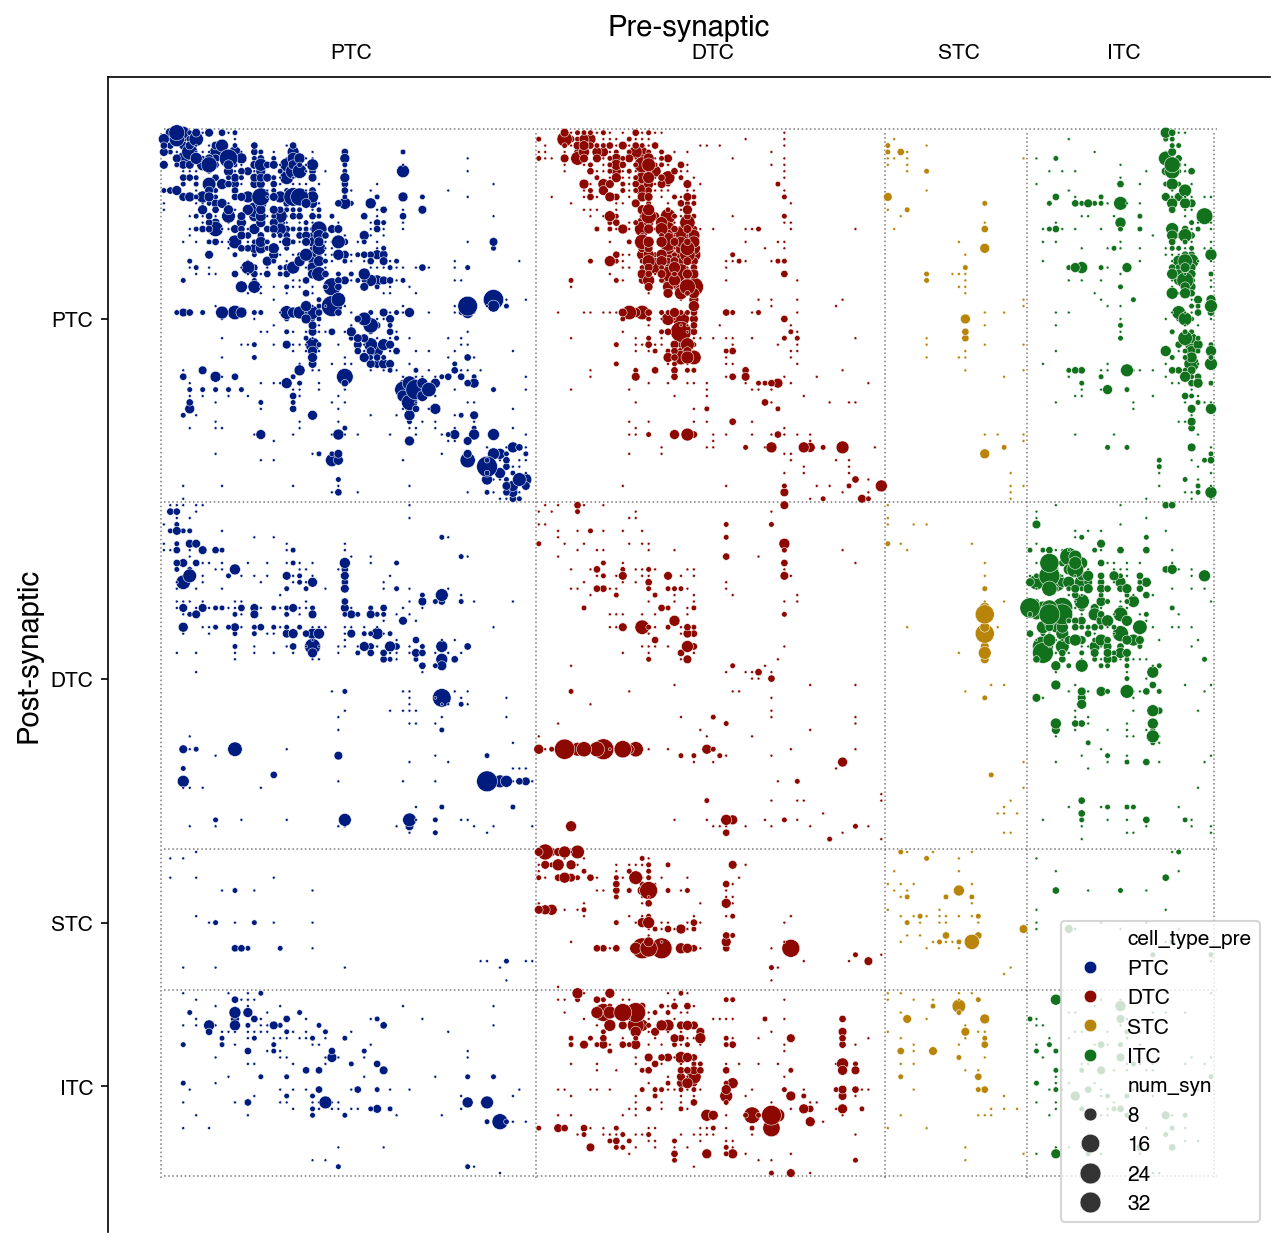

In [76]:
fig, ax = plt.subplots(figsize=(10,10), dpi=150)
sns.scatterplot(
    y='order_post',
    x='order_pre',
    size='num_syn',
    sizes=(2,100),
    size_norm=(1,20),
    data=ii_edgelist,
    hue='cell_type_pre',
    palette=ctype_hues,
    edgecolor='w',
    linewidth=0.25,
    # legend=False,
)
ax.hlines(line_locs-0.5, 0, line_locs[-1], zorder=-10, color='k', alpha=0.5, linestyle=':', linewidth=0.75)
ax.vlines(line_locs-0.5, 0, line_locs[-1], zorder=-10, color='k', alpha=0.5, linestyle=':', linewidth=0.75)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xticks(tick_locs)
ax.set_xticklabels(i_types)
ax.set_xlabel('Pre-synaptic', fontdict={'size': 14})

ax.set_yticks(tick_locs)
ax.set_yticklabels(i_types)
ax.set_ylabel('Post-synaptic', fontdict={'size': 14})
ax.invert_yaxis()
sns.despine(ax=ax, top=False, bottom=True)

if save_figs:
    plt.savefig(f'{plot_dir}/inhib_inhib_adjmat_with_label.pdf', bbox_inches='tight')

In [77]:
eclrs = sns.color_palette('tab20')
e_pal = {k: clr for k, clr in zip(ct_list_exc, eclrs)}

tot_pal = ctype_hues.copy()
tot_pal.update(e_pal)

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_82952/267460143.py:23: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(


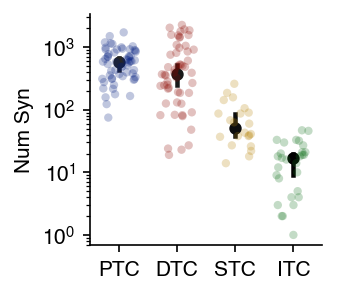

In [78]:
type_count_all = soma_df.groupby('cell_type').count()[['pt_root_id']]

type_count_all = soma_df.groupby('cell_type').count()[['pt_root_id']]
line_locs_all = np.concatenate(([0],type_count_all.cumsum().values.squeeze()))
tick_locs_all = line_locs_all[0:-1]+np.diff(line_locs_all)/2

fig, ax = plt.subplots(figsize=(2,2), dpi=150)
sns.stripplot(
    x="cell_type_pre",
    y="num_syn",
    hue="cell_type_pre",
    palette=ctype_hues,
    data=ie_edgelist.groupby(["pre_pt_root_id", "cell_type_pre"])
    .num_syn.sum()
    .reset_index()
    .query("num_syn>0")
    .reset_index(drop=True),
    size=4,
    jitter=0.3,
    alpha=0.25,
    # zorder=-10,
)
sns.pointplot(
    x="cell_type_pre",
    y="num_syn",
    hue="cell_type_pre",
    data=ie_edgelist.groupby(["pre_pt_root_id", "cell_type_pre"])
    .num_syn.sum()
    .reset_index()
    .query("num_syn>0")
    .reset_index(drop=True),
    color='k',
    estimator=np.median,
    scale=0.8,
    # zorder=10,
)
ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(None)
ax.set_ylabel('Num Syn')
ax.legend().set_visible(False)

if save_figs:
    fig.savefig(f"{plot_dir}/syn_onto_column.pdf", bbox_inches='tight')

In [84]:
(
ie_edgelist.groupby(["pre_pt_root_id", "cell_type_pre"])
    .num_syn.sum()
    .reset_index()
    .query("num_syn>0")
    .reset_index(drop=True)
).set_index('pre_pt_root_id').to_clipboard()

In [ ]:
motif_df['consensus_label'] = motif_df['consensus_label']+1

In [ ]:
postsyn_per_group = (
    ii_edgelist.merge(
        motif_df[["pt_root_id", "consensus_label"]].rename(
            columns={"consensus_label": "motif_post"}
        ),
        left_on="post_pt_root_id",
        right_on="pt_root_id",
    )
    .query('cell_type_pre in ["PTC", "DTC"]')
    .groupby("motif_post")
    ['num_syn'].sum()
)

In [ ]:
motif_syn_df = (
    ii_edgelist.merge(
        motif_df[["pt_root_id", "consensus_label"]].rename(
            columns={"consensus_label": "motif_pre"}
        ),
        left_on="pre_pt_root_id",
        right_on="pt_root_id",
    )
    .drop(columns="pt_root_id")
    .merge(
        motif_df[["pt_root_id", "consensus_label"]].rename(
            columns={"consensus_label": "motif_post"}
        ),
        left_on="post_pt_root_id",
        right_on="pt_root_id",
    )
    .query('cell_type_pre in ["PTC", "DTC"]')
    .pivot_table(
        columns="motif_pre",
        index="motif_post",
        values="num_syn",
        aggfunc="sum",
        fill_value=0,
    )
)

In [ ]:
motif_syn_df

In [ ]:
sns.heatmap((motif_syn_df.T / postsyn_per_group).T, cmap='viridis')

In [ ]:
(
    ii_edgelist.merge(
        motif_df[["pt_root_id", "consensus_label"]].rename(
            columns={"consensus_label": "motif_pre"}
        ),
        left_on="pre_pt_root_id",
        right_on="pt_root_id",
    )
    .drop(columns="pt_root_id")
    .merge(
        motif_df[["pt_root_id", "consensus_label"]].rename(
            columns={"consensus_label": "motif_post"}
        ),
        left_on="post_pt_root_id",
        right_on="pt_root_id",
    )
    .query('cell_type_pre == "PTC"')
    .pivot_table(
        columns="motif_pre",
        index="motif_post",
        values="num_syn",
        aggfunc="sum",
        fill_value=0,
    )
)

In [ ]:
(
    ii_edgelist.merge(
        motif_df[["pt_root_id", "consensus_label"]].rename(
            columns={"consensus_label": "motif_pre"}
        ),
        left_on="pre_pt_root_id",
        right_on="pt_root_id",
    )
    .drop(columns="pt_root_id")
    .merge(
        motif_df[["pt_root_id", "consensus_label"]].rename(
            columns={"consensus_label": "motif_post"}
        ),
        left_on="post_pt_root_id",
        right_on="pt_root_id",
    )
    .query('cell_type_pre == "DTC"')
    .pivot_table(
        columns="motif_pre",
        index="motif_post",
        values="num_syn",
        aggfunc="sum",
        fill_value=0,
    )
)

In [ ]:
iall_edgelist

In [ ]:
save_figs = True

In [ ]:
fig, ax = plt.subplots(figsize=(50,10), dpi=150)
sns.scatterplot(
    x='order_post',
    y='order_pre',
    size='num_syn',
    sizes=(2,100),
    size_norm=(1,15),
    data=iall_edgelist,
    hue='cell_type_pre',
    palette=ctype_hues,
    edgecolor='w',
    linewidth=0.25,
    legend=False,
)
ax.hlines(line_locs-0.5, 0, line_locs_all[-1], zorder=-10, color='k', alpha=0.5, linestyle=':', linewidth=0.75)
ax.vlines(line_locs_all-0.5, 0, line_locs[-1], zorder=-10, color='k', alpha=0.5, linestyle=':', linewidth=0.75)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xticks(tick_locs_all)
ax.set_xticklabels(ct_list_exc+i_types)
ax.set_xlabel('Post-synaptic', fontdict={'size': 14})

ax.set_yticks(tick_locs)
ax.set_yticklabels(i_types)
ax.set_ylabel('Pre-synaptic', fontdict={'size': 14})
ax.invert_yaxis()
sns.despine(ax=ax, top=False, bottom=True)
ax.set_xlim(-10, line_locs_all[-1]+10)
ax.set_ylim(line_locs[-1]+5, -5)

if save_figs:
    plt.savefig(f'{plot_dir}/adjmat_all_motif_ordered.pdf')

In [ ]:
save_figs = True

In [ ]:
fig, ax = plt.subplots(figsize=(4, 7.5), dpi=300)
sns.scatterplot(
    y='order_post',
    x='order_pre',
    size='num_syn',
    sizes=(0.5,30),
    size_norm=(1,40),
    data=ie_edgelist,
    hue='cell_type_pre',
    palette=ctype_hues,
    edgecolor='w',
    linewidth=0.2,
    alpha=0.5,
    legend=True,
)
ax.vlines(line_locs-0.5, 0, line_locs_all[-5], zorder=-10, color='k', alpha=0.5, linestyle=':', linewidth=0.75)
ax.hlines(line_locs_all-0.5, 0, line_locs[-1], zorder=-10, color='k', alpha=0.5, linestyle=':', linewidth=0.75)

sns.despine(ax=ax, top=False, bottom=True, offset=5)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.set_yticks(tick_locs_all[:-4])
ax.set_yticklabels(ct_list_exc, fontdict={'size': 6})
ax.set_ylabel('Post-synaptic', fontdict={'size': 7})

ax.set_xticks(tick_locs)
ax.set_xticklabels(i_types, fontdict={'size': 6})
ax.set_xlabel('Pre-synaptic', fontdict={'size': 7})
# ax.invert_xaxis()
ax.set_ylim(line_locs_all[-5]+10, -10)
ax.set_xlim(-5, line_locs[-1]+5)

plt.tight_layout()
if save_figs:
    # plt.savefig(f'{plot_dir}/adjmat_exc_with_itc.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_dir}/adjmat_exc_with_itc_label.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(7.5,2), dpi=300)
sns.scatterplot(
    x='order_post',
    y='order_pre',
    size='num_syn',
    sizes=(0.25,20),
    size_norm=(1,30),
    data=ie_edgelist.query('cell_type_pre != "ITC"'),
    hue='cell_type_pre',
    palette=ctype_hues,
    edgecolor='w',
    linewidth=0.25,
    alpha=0.75,
    legend=False,
)
ax.hlines(line_locs[:-1]-0.5, 0, line_locs_all[-5], zorder=-10, color='k', alpha=0.5, linestyle=':', linewidth=0.75)
ax.vlines(line_locs_all-0.5, 0, line_locs[-2], zorder=-10, color='k', alpha=0.5, linestyle=':', linewidth=0.75)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

sns.despine(ax=ax, top=False, bottom=True, offset=5)

ax.set_xticks(tick_locs_all[:-4])
ax.set_xticklabels(ct_list_exc, fontdict={'size': 6})
ax.set_xlabel('Post-synaptic', fontdict={'size': 7})

ax.set_yticks(tick_locs[:-1])
ax.set_yticklabels(i_types[:-1], fontdict={'size': 6})
ax.set_ylabel('Pre-synaptic', fontdict={'size': 7})
ax.invert_yaxis()
ax.set_xlim(-10, line_locs_all[-5]+10)
ax.set_ylim(line_locs[-2]+5, -5)

plt.tight_layout()
if save_figs:
    plt.savefig(f'{plot_dir}/adjmat_exc.pdf', bbox_inches='tight')

In [ ]:
pitc_root_ids = motif_df.query('consensus_label == 20').pt_root_id

In [ ]:
pre_idx = iall_edgelist.query('pre_pt_root_id in @pitc_root_ids').index
post_idx = iall_edgelist.query('post_pt_root_id in @pitc_root_ids').index
iall_edgelist["cell_type_pre_spec"] = iall_edgelist["cell_type_pre"].astype(
    pd.CategoricalDtype(ct_list_exc + i_types + ["pITC"], ordered=True)
)
iall_edgelist["cell_type_pre_spec"].loc[pre_idx] = "pITC"

iall_edgelist["cell_type_post_spec"] = iall_edgelist["cell_type_post"].astype(
    pd.CategoricalDtype(ct_list_exc + i_types + ["pITC"], ordered=True)
)
iall_edgelist["cell_type_post_spec"].loc[post_idx] = "pITC"

pre_idx = ii_edgelist.query('pre_pt_root_id in @pitc_root_ids').index
post_idx = ii_edgelist.query('post_pt_root_id in @pitc_root_ids').index
ii_edgelist["cell_type_pre_spec"] = ii_edgelist["cell_type_pre"].astype(
    pd.CategoricalDtype(i_types + ["pITC"], ordered=True)
)
ii_edgelist["cell_type_pre_spec"].loc[pre_idx] = "pITC"

ii_edgelist["cell_type_post_spec"] = ii_edgelist["cell_type_post"].astype(
    pd.CategoricalDtype(i_types + ["pITC"], ordered=True)
)
ii_edgelist["cell_type_post_spec"].loc[post_idx] = "pITC"

In [ ]:
ct_df['cell_type_spec'] = ct_df['cell_type']
ct_df['cell_type_spec'].loc[ct_df.query('pt_root_id in @pitc_root_ids').index] = 'pITC'

In [ ]:
ii_edgelist.groupby('cell_type_pre_spec')['num_syn'].sum()

In [ ]:
agg_syn_matrix

In [ ]:
agg_syn = (
    iall_edgelist.groupby(["cell_type_pre_spec", "cell_type_post_spec"])
    ["num_syn"].sum()
    .loc[i_types + ["pITC"]]
    .reset_index()
)
agg_syn["cell_type_post_spec"] = agg_syn["cell_type_post_spec"].astype(
    pd.CategoricalDtype(["PYC"] + ct_list_exc + i_types + ["pITC"], ordered=True)
)
agg_syn["cell_type_post_spec"] = agg_syn["cell_type_post_spec"].replace(
    {ct: "PYC" for ct in ct_list_exc}
)
agg_syn_matrix = (
    agg_syn.pivot_table(
        index="cell_type_pre_spec", columns="cell_type_post_spec", values="num_syn", aggfunc="sum"
    ).loc[i_types + ["pITC"]]
    / ct_df.replace({ct: "PYC" for ct in ct_list_exc})
    .groupby("cell_type_spec")
    .count()["pt_root_id"]
)

agg_syn_matrix = agg_syn_matrix[i_types + ["pITC"]]

fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
sns.heatmap(
    agg_syn_matrix.loc[i_types + ["pITC"]].T,
    square=True,
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".1f",
    cmap="viridis",
    cbar=False,
)
ax.set_ylabel("Post")
ax.set_xlabel("Pre")

fig.savefig(f"{plot_dir}/average_targeting_simple.pdf", bbox_inches='tight')

In [ ]:
agg_syn = (
    iall_edgelist.groupby(["cell_type_pre", "cell_type_post"])
    ["num_syn"].sum()
    .loc[i_types]
    .reset_index()
)
agg_syn["cell_type_post"] = agg_syn["cell_type_post"].astype(
    pd.CategoricalDtype(["PYC"] + ct_list_exc + i_types, ordered=True)
)
agg_syn["cell_type_post"] = agg_syn["cell_type_post"].replace(
    {ct: "PYC" for ct in ct_list_exc}
)
agg_syn_matrix = (
    agg_syn.pivot_table(
        index="cell_type_pre", columns="cell_type_post", values="num_syn", aggfunc="sum"
    ).loc[i_types]
    / ct_df.replace({ct: "PYC" for ct in ct_list_exc})
    .groupby("cell_type")
    .count()["pt_root_id"]
)
# agg_syn_matrix = agg_syn_matrix[["PYC"] + i_types]
agg_syn_matrix = agg_syn_matrix[i_types]
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
sns.heatmap(
    agg_syn_matrix.loc[i_types].T,
    square=True,
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".1f",
    cmap="viridis",
    vmax=43,
    vmin=0,
    cbar=True,
)
ax.set_ylabel("Post")
ax.set_xlabel("Pre")
# ax.vlines(1, ax.get_ylim()[0], ax.get_ylim()[1], color="w")

fig.savefig(f"{plot_dir}/average_targeting_simple.pdf", bbox_inches='tight')

In [ ]:
753.55-537.04

In [ ]:
layer_bounds

In [ ]:
agg_syn = iall_edgelist.groupby(['cell_type_pre', 'cell_type_post'])['num_syn'].sum().loc[i_types].reset_index()
agg_syn['cell_type_post'] = agg_syn['cell_type_post'].astype(pd.CategoricalDtype(['PYC'] + ct_list_exc + i_types, ordered=True))
agg_syn['cell_type_post'] = agg_syn['cell_type_post'].replace({ct: "PYC" for ct in ct_list_exc})
agg_syn_matrix = agg_syn.pivot_table(index='cell_type_pre', columns='cell_type_post', values='num_syn', aggfunc='sum').loc[i_types] / ct_df.replace({ct: "PYC" for ct in ct_list_exc}).groupby('cell_type').count()['pt_root_id']
agg_syn_matrix = agg_syn_matrix[["PYC"] + i_types]

fig, ax = plt.subplots(figsize=(3,2), dpi=300)
sns.heatmap(
    agg_syn_matrix.loc[i_types],
    square=True,
    annot=True,
    annot_kws={'fontsize': 7},
    fmt=".1f",
    cmap='viridis',
    vmax=45,
    vmin=0,
    cbar=False,
)
ax.set_xlabel('Post')
ax.set_ylabel('Pre')
ax.vlines(1, ax.get_ylim()[0], ax.get_ylim()[1], color='w')

# fig.savefig(f"{plot_dir}/average_targeting_simple.pdf", bbox_inches='tight')

In [ ]:
agg_syn = iall_edgelist.groupby(['cell_type_pre', 'cell_type_post'])['num_syn'].sum().loc[i_types].reset_index()
agg_syn['cell_type_post'] = agg_syn['cell_type_post'].astype(pd.CategoricalDtype(ct_list_exc, ordered=True))
agg_syn_matrix = agg_syn.pivot_table(index='cell_type_pre', columns='cell_type_post', values='num_syn', aggfunc='sum').loc[i_types] / ct_df.groupby('cell_type').count()['pt_root_id']
agg_syn_matrix = agg_syn_matrix[ct_list_exc]

fig, ax = plt.subplots(figsize=(2, 6), dpi=300)
sns.heatmap(
    agg_syn_matrix.loc[i_types].T,
    square=True,
    annot=True,
    annot_kws={'fontsize': 7},
    fmt=".1f",
    cmap='viridis',
    cbar=False,
)
ax.set_ylabel('Post')
ax.set_xlabel('Pre')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
fig.savefig(f"{plot_dir}/average_targeting_ct_level_eonly.pdf", bbox_inches='tight')

In [ ]:
agg_syn = iall_edgelist.groupby(['cell_type_pre', 'cell_type_post'])['num_syn'].sum().loc[i_types].reset_index()
agg_syn['cell_type_post'] = agg_syn['cell_type_post'].astype(pd.CategoricalDtype(ct_list_exc + i_types, ordered=True))
agg_syn_matrix = agg_syn.pivot_table(index='cell_type_pre', columns='cell_type_post', values='num_syn', aggfunc='sum').loc[i_types] / ct_df.groupby('cell_type').count()['pt_root_id']
agg_syn_matrix = agg_syn_matrix[ct_list_exc + i_types]

fig, ax = plt.subplots(figsize=(10, 2), dpi=300)
sns.heatmap(
    agg_syn_matrix.loc[i_types],
    square=True,
    annot=True,
    annot_kws={'fontsize': 7},
    fmt=".1f",
    cmap='viridis',
    cbar=False,
)
ax.set_xlabel('Post')
ax.set_ylabel('Pre')
ax.vlines(len(ct_list_exc), ax.get_ylim()[0], ax.get_ylim()[1], color='w')
fig.savefig(f"{plot_dir}/average_targeting_ct_level.pdf", bbox_inches='tight')

In [ ]:
syn_i_df['net_syn'] = syn_i_df.groupby('pre_pt_root_id').transform('count')['id']
syn_i_df['cell_type_pre'] = syn_i_df['cell_type_pre'].astype(pd.CategoricalDtype(i_types, ordered=True))
syn_i_df= syn_i_df.merge(
    ct_df[['pt_root_id', 'soma_depth']],
    how='left',
    left_on='pre_pt_root_id',
    right_on='pt_root_id',
)

In [ ]:
fig, ax = plt.subplots(figsize=(1.5,4), dpi=150)
sns.scatterplot(
    x='net_syn',
    y='soma_depth',
    hue='cell_type_pre',
    palette=ctype_hues,
    data=syn_i_df.drop_duplicates('pre_pt_root_id'),
    ax=ax,
    size=3,
    legend=False,
    alpha=0.85,
)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    linewidth=1,
    linestyle=':',
    color=(0.5, 0.5, 0.5),
    alpha=0.5,
    ax=ax,
)

ax.set_ylim(height_bounds[1]-60, height_bounds[0])
ax.set_xscale('log')
sns.despine(ax=ax)

ax.set_xlabel('# Syn onto column cells')
ax.set_ylabel('Soma depth')
fig.savefig(f'{plot_dir}/inhib_cell_type_depth_dist.pdf', bbox_inches='tight')

In [ ]:
ct_df.groupby('cell_type').count().loc[i_types]

In [ ]:
ct_df['soma_x'] = tform.apply_project('x', ct_df['pt_position']) 
ct_df['soma_y'] = tform.apply_project('y', ct_df['pt_position']) 
ct_df['soma_z'] = tform.apply_project('z', ct_df['pt_position']) 

In [ ]:
syn_i_df.rename(columns={'pt_root_id_x': 'pt_root_id'}, inplace=True)

In [ ]:
spatial_syn_table = syn_i_df.merge(
    ct_df[["pt_root_id", "soma_x", "soma_y", "soma_z"]].rename(
        columns={"soma_x": "post_soma_x", "soma_y": "post_soma_y", "soma_z": "post_soma_z"}
    ),
    on="pt_root_id",
    how="left",
).merge(
    ct_df[["pt_root_id", "soma_x", "soma_y", "soma_z"]].rename(
        columns={"soma_x": "pre_soma_x", "soma_y": "pre_soma_y", "soma_z": "pre_soma_z", "pt_root_id": 'pre_pt_root_id'}
    ),
    on="pre_pt_root_id",
    how="left",
)

In [ ]:
spatial_syn_table['syn_in_conn'] = spatial_syn_table.groupby(['pre_pt_root_id', 'post_pt_root_id']).transform('count')['id']

In [ ]:
spatial_conn_table = spatial_syn_table.drop_duplicates(subset=['pre_pt_root_id', 'post_pt_root_id'])

In [ ]:
motif_df = pd.read_feather(f'paper_versions/v{version}/data/inhibitory_motif_table.feather')

In [ ]:
simple_table= spatial_conn_table[['pre_pt_root_id', 'post_pt_root_id', 'cell_type_pre', 'cell_type_post', 'pre_soma_x', 'pre_soma_y', 'post_soma_x', 'post_soma_y', 'post_soma_z', 'pre_soma_z', 'syn_in_conn']]

simple_table = simple_table.merge(
    motif_df[['pre_pt_root_id', 'consensus_label']],
    on='pre_pt_root_id',
)

In [ ]:
with open(f"{data_dir}/ctype_hues.pkl", "rb") as f:
    ctype_hues = pickle.load(f)

In [ ]:
def alpha_func(sc, sh, lm):
    return 1 / (1+np.exp(-2*(sc - sh)/lm))

In [ ]:
0.2 * alpha_func( 20, 2, 3)

In [ ]:
ct_list = ["L2a", "L2b", "L3a", "L4b"]
motif_groups = [0, 1, 3, 6]

fig, axes = plt.subplots(
    figsize=(1 * len(ct_list), 2*len(motif_groups)), nrows=len(motif_groups), ncols=len(ct_list), dpi=150, sharey=True,
)


for mg, ax_row in zip(motif_groups, axes):
    for ax, ct in zip(ax_row, ct_list):

        ct_post = [ct]

        pre_select = simple_table.query("cell_type_post in @ct_post and consensus_label == @mg").reset_index(drop=True)
        pre_select["net_syn"] = pre_select.groupby("pre_pt_root_id")[
            "syn_in_conn"
        ].transform("sum")
        pre_select["net_syn"] = pre_select["net_syn"] / len(
            pre_select["post_pt_root_id"].unique()
        )
        pre_select.drop_duplicates(subset="pre_pt_root_id", inplace=True)

        for _, row in simple_table.query(
            "cell_type_post in @ct_post and syn_in_conn>1 and consensus_label == @mg"
        ).iterrows():
            xs = row[["pre_soma_x", "post_soma_x"]].values
            ys = row[["pre_soma_y", "post_soma_y"]].values
            ax.plot(
                xs,
                ys,
                linewidth=0.5,
                alpha=0.3 * alpha_func(row["syn_in_conn"], 2, 4),
                color=ctype_hues[row["cell_type_pre"]],
                zorder=0,
            ),

        sns.scatterplot(
            x="pre_soma_x",
            y="pre_soma_y",
            size="net_syn",
            sizes=(2, 75),
            size_norm=(1, 4),
            hue="cell_type_pre",
            palette=ctype_hues,
            data=pre_select,
            legend=False,
            edgecolor="w",
            linewidth=0.5,
            zorder=20,
            ax=ax,
        )
        
        sns.scatterplot(
            x="post_soma_x",
            y="post_soma_y",
            s=2,
            color = 'k',
            data=simple_table.query("cell_type_post in @ct_post").reset_index(drop=True).drop_duplicates('post_pt_root_id'),
            legend=False,
            zorder=21,
            ax=ax,
            alpha=0.5
        )

        ax.set_xlim(580, 780)
        plotting_code.plot_layers(
            layer_bounds,
            height_bounds - [0, 120],
            ax.get_xlim(),
            ax=ax,
            linewidth=1,
            color=(0.5, 0.5, 0.5),
            linestyle=":",
            zorder=-20,
        )
        ax.xaxis.set_visible(False)
        ax.set_aspect("equal")
        sns.despine(ax=ax, offset=3, bottom=True)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        if mg == motif_groups[0]:
            ax.set_title(ct)
        if ct == ct_list[0]:
            ax.set_ylabel(f"Motif group {mg}")
ax.set_ylim(height_bounds[1]-350, 0)

plt.tight_layout()
fig.savefig(f"{plot_dir}/upper_layer_conn_examples.pdf")

In [ ]:
ct_list_exc[7:10]

In [ ]:
ct_list = ["L5a", "L5b", "L5ET", "L5NP"]
motif_groups = [8, 9, 12]

fig, axes = plt.subplots(
    figsize=(1 * len(ct_list), 2*len(motif_groups)), nrows=len(motif_groups), ncols=len(ct_list), dpi=150, sharey=True,
)


for mg, ax_row in zip(motif_groups, axes):
    for ax, ct in zip(ax_row, ct_list):

        ct_post = [ct]

        pre_select = simple_table.query("cell_type_post in @ct_post and consensus_label == @mg").reset_index(drop=True)
        pre_select["net_syn"] = pre_select.groupby("pre_pt_root_id")[
            "syn_in_conn"
        ].transform("sum")
        pre_select["net_syn"] = pre_select["net_syn"] / len(
            pre_select["post_pt_root_id"].unique()
        )
        pre_select.drop_duplicates(subset="pre_pt_root_id", inplace=True)

        for _, row in simple_table.query(
            "cell_type_post in @ct_post and syn_in_conn>1 and consensus_label == @mg"
        ).iterrows():
            xs = row[["pre_soma_x", "post_soma_x"]].values
            ys = row[["pre_soma_y", "post_soma_y"]].values
            ax.plot(
                xs,
                ys,
                linewidth=1,
                alpha=0.3 * alpha_func(row["syn_in_conn"], 2, 4),
                color=ctype_hues[row["cell_type_pre"]],
                zorder=0,
            ),

        sns.scatterplot(
            x="pre_soma_x",
            y="pre_soma_y",
            size="net_syn",
            sizes=(2, 75),
            size_norm=(1, 4),
            hue="cell_type_pre",
            palette=ctype_hues,
            data=pre_select,
            legend=False,
            edgecolor="w",
            linewidth=0.5,
            zorder=20,
            ax=ax,
        )
        
        sns.scatterplot(
            x="post_soma_x",
            y="post_soma_y",
            s=2,
            color = 'k',
            data=simple_table.query("cell_type_post in @ct_post").reset_index(drop=True).drop_duplicates('post_pt_root_id'),
            legend=False,
            zorder=21,
            ax=ax,
            alpha=0.5
        )

        ax.set_xlim(580, 780)
        plotting_code.plot_layers(
            layer_bounds,
            height_bounds - [0, 120],
            ax.get_xlim(),
            ax=ax,
            linewidth=1,
            color=(0.5, 0.5, 0.5),
            linestyle=":",
            zorder=-20,
        )
        ax.xaxis.set_visible(False)
        ax.set_aspect("equal")
        sns.despine(ax=ax, offset=3, bottom=True)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        if mg == motif_groups[0]:
            ax.set_title(ct)
        if ct == ct_list[0]:
            ax.set_ylabel(f"Motif group {mg}")
            
ax.set_ylim(height_bounds[1]-250, height_bounds[0]+150)
plt.tight_layout()
fig.savefig(f"{plot_dir}/lower_layer_conn_examples.pdf")

In [ ]:
ct_list = ct_list_exc[10:]
motif_groups = [11, 12, 13]

fig, axes = plt.subplots(
    figsize=(1 * len(ct_list), 3*len(motif_groups)), nrows=len(motif_groups), ncols=len(ct_list), dpi=150, sharey=True,
)


for mg, ax_row in zip(motif_groups, axes):
    for ax, ct in zip(ax_row, ct_list):

        ct_post = [ct]

        pre_select = simple_table.query("cell_type_post in @ct_post and consensus_label == @mg").reset_index(drop=True)
        pre_select["net_syn"] = pre_select.groupby("pre_pt_root_id")[
            "syn_in_conn"
        ].transform("sum")
        pre_select["net_syn"] = pre_select["net_syn"] / len(
            pre_select["post_pt_root_id"].unique()
        )
        pre_select.drop_duplicates(subset="pre_pt_root_id", inplace=True)

        for _, row in simple_table.query(
            "cell_type_post in @ct_post and syn_in_conn>1 and consensus_label == @mg"
        ).iterrows():
            xs = row[["pre_soma_x", "post_soma_x"]].values
            ys = row[["pre_soma_y", "post_soma_y"]].values
            ax.plot(
                xs,
                ys,
                linewidth=1,
                alpha=0.3 * alpha_func(row["syn_in_conn"], 2, 4),
                color=ctype_hues[row["cell_type_pre"]],
                zorder=0,
            ),

        sns.scatterplot(
            x="pre_soma_x",
            y="pre_soma_y",
            size="net_syn",
            sizes=(2, 75),
            size_norm=(1, 4),
            hue="cell_type_pre",
            palette=ctype_hues,
            data=pre_select,
            legend=False,
            edgecolor="w",
            linewidth=0.5,
            zorder=20,
            ax=ax,
        )
        
        sns.scatterplot(
            x="post_soma_x",
            y="post_soma_y",
            s=2,
            color = 'k',
            data=simple_table.query("cell_type_post in @ct_post").reset_index(drop=True).drop_duplicates('post_pt_root_id'),
            legend=False,
            zorder=21,
            ax=ax,
            alpha=0.5
        )

        ax.set_xlim(580, 780)
        plotting_code.plot_layers(
            layer_bounds,
            height_bounds - [0, 120],
            ax.get_xlim(),
            ax=ax,
            linewidth=1,
            color=(0.5, 0.5, 0.5),
            linestyle=":",
            zorder=-20,
        )
        ax.xaxis.set_visible(False)
        ax.set_aspect("equal")
        sns.despine(ax=ax, offset=3, bottom=True)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        if mg == motif_groups[0]:
            ax.set_title(ct)
        if ct == ct_list[0]:
            ax.set_ylabel(f"Motif group {mg}")
plt.tight_layout()


In [ ]:
np.sort(motif_df.consensus_label.unique())

In [ ]:
ct_list = ct_list_exc
motif_groups = np.sort(motif_df.consensus_label.unique())

fig, axes = plt.subplots(
    figsize=(1 * len(ct_list), 3*len(motif_groups)), nrows=len(motif_groups), ncols=len(ct_list), dpi=150, sharey=True,
)


for mg, ax_row in zip(motif_groups, axes):
    for ax, ct in zip(ax_row, ct_list):

        ct_post = [ct]

        pre_select = simple_table.query("cell_type_post in @ct_post and consensus_label == @mg").reset_index(drop=True)
        pre_select["net_syn"] = pre_select.groupby("pre_pt_root_id")[
            "syn_in_conn"
        ].transform("sum")
        pre_select["net_syn"] = pre_select["net_syn"] / len(
            pre_select["post_pt_root_id"].unique()
        )
        pre_select.drop_duplicates(subset="pre_pt_root_id", inplace=True)

        for _, row in simple_table.query(
            "cell_type_post in @ct_post and syn_in_conn>1 and consensus_label == @mg"
        ).iterrows():
            xs = row[["pre_soma_x", "post_soma_x"]].values
            ys = row[["pre_soma_y", "post_soma_y"]].values
            ax.plot(
                xs,
                ys,
                linewidth=1,
                alpha=0.3 * alpha_func(row["syn_in_conn"], 2, 4),
                color=ctype_hues[row["cell_type_pre"]],
                zorder=0,
            ),

        sns.scatterplot(
            x="pre_soma_x",
            y="pre_soma_y",
            size="net_syn",
            sizes=(2, 75),
            size_norm=(1, 4),
            hue="cell_type_pre",
            palette=ctype_hues,
            data=pre_select,
            legend=False,
            edgecolor="w",
            linewidth=0.5,
            zorder=20,
            ax=ax,
        )
        
        sns.scatterplot(
            x="post_soma_x",
            y="post_soma_y",
            s=2,
            color = 'k',
            data=simple_table.query("cell_type_post in @ct_post").reset_index(drop=True).drop_duplicates('post_pt_root_id'),
            legend=False,
            zorder=21,
            ax=ax,
            alpha=0.5
        )

        ax.set_xlim(580, 780)
        plotting_code.plot_layers(
            layer_bounds,
            height_bounds - [0, 120],
            ax.get_xlim(),
            ax=ax,
            linewidth=1,
            color=(0.5, 0.5, 0.5),
            linestyle=":",
            zorder=-20,
        )
        ax.xaxis.set_visible(False)
        ax.set_aspect("equal")
        sns.despine(ax=ax, offset=3, bottom=True)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        if mg == motif_groups[0]:
            ax.set_title(ct)
        if ct == ct_list[0]:
            ax.set_ylabel(f"Motif group {mg}")
plt.tight_layout()
fig.savefig(f"{plot_dir}/all_conn_examples.pdf")

In [ ]:
simple_table.groupby(
    ["post_pt_root_id", "consensus_label"]
).syn_in_conn.sum().reset_index().sort_values(by="syn_in_conn", ascending=False)

In [ ]:
pd.NamedAgg?

In [ ]:
ctype_hues_alt = ctype_hues.copy()

In [ ]:
simple_table.head()

In [ ]:
con_label = simple_table.drop_duplicates(["pre_pt_root_id", "consensus_label"])[
    ["pre_pt_root_id", "consensus_label"]
].set_index("pre_pt_root_id")

In [ ]:
sns.heatmap(
    simple_table.groupby(["pre_pt_root_id", "cell_type_post"])
    .agg(num_syn=pd.NamedAgg("syn_in_conn", "sum"))
    .reset_index()
    .merge(con_label, left_on="pre_pt_root_id", right_index=True)
    .pivot_table(
        columns="consensus_label",
        index="cell_type_post",
        values="num_syn",
        fill_value=0,
        aggfunc="sum",
    )
    .corr('spearman'),
    center=0,
    cmap='RdBu_r',
    square=True,
)

In [ ]:
sns.color_palette('tab20b')

In [ ]:
sns.color_palette('tab20c')

In [ ]:
clrs_alt = sns.color_palette('tab20c')
clrs_alt2 = sns.color_palette('tab20b')

ctype_hues_alt['L2a'] = clrs_alt[0]
ctype_hues_alt['L2b'] = clrs_alt[1]

ctype_hues_alt['L3a'] = clrs_alt[4]
ctype_hues_alt['L3b'] = clrs_alt[5]
ctype_hues_alt['L3c'] = clrs_alt[6]

ctype_hues_alt['L4a'] = clrs_alt[8]
ctype_hues_alt['L4b'] = clrs_alt[9]
ctype_hues_alt['L4c'] = clrs_alt[10]

ctype_hues_alt['L5a'] = clrs_alt[12]
ctype_hues_alt['L5b'] = clrs_alt[13]
ctype_hues_alt['L5ET'] = clrs_alt[14]
ctype_hues_alt['L5NP'] = clrs_alt[15]

ctype_hues_alt['L6a'] = clrs_alt2[12]
ctype_hues_alt['L6b'] = clrs_alt2[13]
ctype_hues_alt['L6CT'] = clrs_alt2[14]
ctype_hues_alt['L6c'] = clrs_alt2[15]

ctype_hues_alt['L6wm'] = (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)

import dill as pickle

with open(f"{data_dir}/ctype_hues.pkl", "wb") as f:
    pickle.dump(ctype_hues_alt, f)

In [ ]:
# mg = 14
motif_group_df = (
    simple_table.query("consensus_label == @mg")
    .groupby(["pre_pt_root_id", "cell_type_post"])
    .agg(
        num_cell=pd.NamedAgg("syn_in_conn", "count"),
        net_syn=pd.NamedAgg("syn_in_conn", "sum"),
        mean_syn=pd.NamedAgg("syn_in_conn", "mean"),
    )
    .reset_index()
    .merge(
        dfct_e.groupby("hlabel").count()["root_id"].rename("num_cell_all"),
        left_on="cell_type_post",
        right_index=True,
    )
)
motif_group_df["targ_density"] = (
    motif_group_df["num_cell"] / motif_group_df["num_cell_all"]
)

In [ ]:
import statsmodels.api as sm

In [ ]:
l5_types = ["L5a", "L5b", "L5ET","L5NP"]
# l5_types = ["L2a", "L2b", "L3a", "L3b", "L3c", "L4a", "L4b", "L4c"]

anova_res = sm.stats.anova_oneway(
    data = motif_group_df.query('cell_type_post in @l5_types')['targ_density'],
    groups = motif_group_df.query('cell_type_post in @l5_types')['cell_type_post'],
)

In [ ]:
motif_group_df=motif_group_df.dropna()
tukey_res = sm.stats.multicomp.pairwise_tukeyhsd(
    motif_group_df.query("cell_type_post in @l5_types")["targ_density"],
    groups=motif_group_df.query("cell_type_post in @l5_types")["cell_type_post"],
)

In [ ]:
tukey_res.summary()

In [ ]:
stats.ttest_ind(
    motif_group_df.query('cell_type_post == "L5ET"')['targ_density'],
    motif_group_df.query('cell_type_post == "L5a"')['targ_density'],
)

In [ ]:
from nglui import statebuilder
from caveclient import CAVEclient

client = CAVEclient('minnie65_phase3_v1')

In [ ]:
ng_df = syn_i_df.copy()

In [ ]:
ng_df['rad'] = 50

In [ ]:
img, seg = statebuilder.from_client(client)
anno = statebuilder.AnnotationLayerConfig(
    'syn',
    mapping_rules=statebuilder.LineMapper('pre_pt_position', 'post_pt_position', linked_segmentation_column=['pre_pt_root_id', 'post_pt_root_id']),
    linked_segmentation_layer=seg.name,
    color='turquoise',
)
anno2 = statebuilder.AnnotationLayerConfig(
    'pre',
    mapping_rules=statebuilder.SphereMapper('pre_pt_position', 'rad', linked_segmentation_column=['pre_pt_root_id', 'post_pt_root_id']),
    linked_segmentation_layer=seg.name,
    color='tomato',
)
sb = statebuilder.StateBuilder([img, seg, anno, anno2], client=client)
sb.render_state(
    ng_df.query('cell_type_post in @i_types').query('is_dendrite == False and is_soma == False'),
    return_as='html',
)

In [ ]:
syn_i_df.columns

In [ ]:
syn_i_df.query('cell_type_post in @i_types').query('is_dendrite == True').groupby(['pre_pt_root_id', 'post_pt_root_id']).count()

In [ ]:
itc_ptc_df = syn_i_df.query('cell_type_pre == "ITC" and cell_type_post in ["PTC"]').groupby(
    ["post_pt_root_id", "cell_type_post"]
).count().replace({0: np.nan}).reset_index().query('cell_type_post in ["PTC"]').pivot_table('id', 'post_pt_root_id', 'cell_type_post').fillna(0)

In [ ]:
bc_mol_df = client.materialize.query_table('allen_column_basket_molecular', timestamp=client.materialize.get_timestamp(507))

In [ ]:
itc_ptc_df.sort_values(by='PTC', ascending=False).merge(bc_mol_df[['pt_root_id', 'cell_type']], left_index=True, right_on='pt_root_id').shape

In [ ]:
bc_mol_df

In [ ]:
itc_ptc_df.sort_values(by='PTC', ascending=False)

In [ ]:
ptc_ptc_df = syn_i_df.query('cell_type_pre == "PTC" and cell_type_post in ["PTC", "ITC"]').groupby(
    ["pre_pt_root_id", "cell_type_post"]
).count().replace({0: np.nan}).reset_index().query('cell_type_post in ["PTC", "ITC"]').pivot_table('id', 'pre_pt_root_id', 'cell_type_post').fillna(0)

In [ ]:
np.std(ptc_ptc_df['PTC']) / np.mean(ptc_ptc_df['PTC'])

In [ ]:
np.std(ptc_itc_df['PTC']) / np.mean(ptc_itc_df['PTC'])

In [ ]:
ptc_itc_df = syn_i_df.query('cell_type_pre == "DTC" and cell_type_post in ["PTC", "ITC"]').groupby(
    ["pre_pt_root_id", "cell_type_post"]
).count().replace({0: np.nan}).reset_index().query('cell_type_post in ["PTC", "ITC"]').pivot_table('id', 'pre_pt_root_id', 'cell_type_post').fillna(0)

In [ ]:
ptc_itc_df['total'] = ptc_itc_df['PTC'] + ptc_itc_df['ITC']

ptc_itc_df['itc_frac'] = ptc_itc_df['ITC'] / ptc_itc_df['total']
ptc_itc_df['ptc_frac'] = ptc_itc_df['PTC'] / ptc_itc_df['total']

In [ ]:
ptc_itc_df.sort_values(by='PTC', ascending=False)

In [ ]:
ptc_itc_df['PTC']

In [ ]:
ptc_itc_df.query('total>30').sort_values(by='itc_frac')

In [ ]:
ptc_itc_df.sort_values(by='PTC', ascending=False).iloc[0:6]['ptc_frac'].mean()

In [ ]:
motif_group_df.query('cell_type_post == "L5ET"')

In [ ]:
for mg in np.arange(18):
    motif_group_df = (
        simple_table.query("consensus_label == @mg")
        .groupby(["pre_pt_root_id", "cell_type_post"])
        .agg(
            num_cell=pd.NamedAgg("syn_in_conn", "count"),
            net_syn=pd.NamedAgg("syn_in_conn", "sum"),
            mean_syn=pd.NamedAgg("syn_in_conn", "mean"),
        )
        .reset_index()
        .merge(
            dfct_e.groupby("hlabel").count()["root_id"].rename("num_cell_all"),
            left_on="cell_type_post",
            right_index=True,
        )
    )
    motif_group_df["targ_density"] = (
        motif_group_df["num_cell"] / motif_group_df["num_cell_all"]
    )

    fig, axes = plt.subplots(figsize=(2, 1.5), ncols=2, dpi=300, sharey=True)

    ax = axes[0]

    sns.barplot(
        y="cell_type_post",
        x="targ_density",
        hue="cell_type_post",
        palette=ctype_hues,
        data=motif_group_df,
        alpha=1,
        ax=ax,
        zorder=0,
        dodge=False,
        errwidth=0,
        estimator=np.nanmedian,        
    )

    sns.swarmplot(
        y="cell_type_post",
        x="targ_density",
        color="k",
        data=motif_group_df,
        alpha=1,
        ax=ax,
        zorder=0,
        s=0.75,
        edgecolor='k',
        linewidth=0.2,
    )

    ax.yaxis.set_tick_params(rotation=0, labelsize=4)
    ax.xaxis.set_tick_params(rotation=0, labelsize=4)
    ax.set_xlim(-0.05, 1.05)
    ax.set_xticks([0,0.25, 0.5,0.75, 1])

    sns.despine(ax=ax, offset=1, trim=True)
    ax.set_ylabel(None)
    ax.set_xlabel("Connection Density", fontdict={"size": 5})
    ax.legend().set_visible(False)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    
    ax = axes[1]
    sns.barplot(
        y="cell_type_post",
        x="mean_syn",
        hue="cell_type_post",
        palette=ctype_hues,
        data=motif_group_df,
        alpha=1,
        ax=ax,
        zorder=0,
        dodge=False,
        errwidth=0,
        estimator=np.nanmedian,
    )

    sns.swarmplot(
        y="cell_type_post",
        x="mean_syn",
        color="k",
        data=motif_group_df,
        alpha=1,
        ax=ax,
        zorder=0,
        s=0.75,
        edgecolor='k',
        linewidth=0.2,
    )

    ax.xaxis.set_tick_params(rotation=0, labelsize=4)
    ax.yaxis.set_tick_params(rotation=0, labelsize=4)
    ax.set_xlim(0.5, 8)
    ax.set_xticks(np.arange(1, 9))
    ax.set_ylabel(None)
    ax.set_xlabel("Syn. per Connection", fontdict={"size": 5})

    sns.despine(ax=ax, offset=1, trim=True)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)

    ax.legend().set_visible(False)
    fig.suptitle(f"{mg}", fontsize=5)
    fig.savefig(f"{plot_dir}/targeting_properties_motif_{mg}.pdf", bbox_inches="tight")


In [ ]:
input_mapped_df = dfct_e.merge(
    simple_table.groupby(["post_pt_root_id", "consensus_label"])
    .syn_in_conn.sum()
    .reset_index()
    .sort_values(by="syn_in_conn", ascending=False),
    left_on="root_id",
    right_on="post_pt_root_id",
    how="inner",
)

In [ ]:
input_mapped_df.query('consensus_label==5 and hlabel=="L5-IT"').syn_in_conn.describe()

In [ ]:
input_mapped_df.query('consensus_label==5 and hlabel=="L4b"').syn_in_conn.describe()

In [ ]:
input_mapped_df.query('consensus_label==@mg').syn_in_conn.max()

In [ ]:
for mg in np.arange(17):
                    
    fig, ax = plt.subplots(figsize=(5,3), dpi=300)

    sns.scatterplot(
        x='umap0_raw',
        y='umap1_raw',
        s=1,
        color='k',
        data=dfct_e,
        ax=ax,
        alpha=0.25,
    )

    sns.scatterplot(
        x='umap0_raw',
        y='umap1_raw',
        size='syn_in_conn',
        size_norm=(1,input_mapped_df.query('consensus_label==@mg').syn_in_conn.max()),
        sizes=(1,100),
        hue='hlabel',
        palette=ctype_hues,
        data=input_mapped_df.query('consensus_label==@mg'),
        ax=ax,
        legend=None,
        edgecolor='k'
    )
    ax.set_aspect('equal')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(f"Motif group {mg}")
    fig.savefig(f"{plot_dir}/umap_motif_{mg}_plot.pdf", bbox_inches='tight')

In [ ]:
def get_random_cells(df, label, n):
    return df.query('hlabel == @label').sample(n)[['umap0_raw', 'umap1_raw']].values

In [ ]:
observed_cells = input_mapped_df.query('consensus_label == 0 and hlabel =="L3"')[['umap0_raw', 'umap1_raw']]
random_cells = get_random_cells(dfct_e, 'L3', len(observed_cells))

In [ ]:
from scipy import spatial

In [ ]:
x1 = get_random_cells(dfct_e, 'L3', len(observed_cells))
x2 = get_random_cells(dfct_e, 'L3', len(observed_cells))

kdt1 = spatial.KDTree(x1)
kdt2 = spatial.KDTree(x2)

d12, _ = kdt1.query(x2)
d21, _ = kdt2.query(x1)

np.mean(d12) + np.mean(d21)

In [ ]:
def chamfer_distance(x1, x2):
    kdt1 = spatial.KDTree(x1)
    kdt2 = spatial.KDTree(x2)

    d12, _ = kdt1.query(x2)
    d21, _ = kdt2.query(x1)

    return np.mean(d12) + np.mean(d21) 

In [ ]:
ct = "L3"

motif_group = 3

ntimes = 100

observed_cells = input_mapped_df.query('consensus_label == @motif_group and hlabel == @ct')[
    ["umap0_raw", "umap1_raw"]
]

rand_dists = []
obs_dists = []
for ii in range(ntimes):
    rand_dists.append(
        chamfer_distance(
            get_random_cells(dfct_e, ct, len(observed_cells)),
            get_random_cells(dfct_e, ct, len(observed_cells)),
        )
    )
    
    obs_dists.append(
        chamfer_distance(
            observed_cells,
            get_random_cells(dfct_e, ct, len(observed_cells)),
        )
    )

    

In [ ]:
stats.ks_2samp(obs_dists, rand_dists)

In [ ]:
post_syn_matrix = syn_i_df_ct.drop_duplicates(subset='post_pt_root_id').set_index('post_pt_root_id').pivot_table(
    values='syn_in_conn',
    index='post_pt_root_id',
    columns='pre_pt_root_id',
    aggfunc='sum',
    fill_value=0,
)
syn_cols = post_syn_matrix.columns

post_syn_matrix = post_syn_matrix.merge(
    ct_df[['pt_root_id', 'cell_type', 'soma_x', 'soma_y', 'soma_z']],
    left_index=True,
    right_on='pt_root_id',
    how='left',
).drop(columns='pt_root_id')
    

In [ ]:
from sklearn import decomposition

In [ ]:
pca = decomposition.PCA(n_components=31)
X = pca.fit_transform(post_syn_matrix[syn_cols])

In [ ]:
import umap
red = umap.UMAP(
    metric='euclidean',
    densmap=True,
    n_neighbors = 10,
    min_dist=0.99,
)

data = post_syn_matrix.query('cell_type in ["L2high", "L2low", "L3", "L4low", "L4high"]')
keep_cols = syn_cols[data[syn_cols].sum(axis=0)>0]

Xu = red.fit_transform(data[keep_cols]>1)
data['umap0'] = Xu[:,0]
data['umap1'] = Xu[:,1]

In [ ]:
fig, axes = plt.subplots(figsize=(2*len(i_types), 6), ncols=len(i_types), dpi=150)

for ax, ct in zip(axes, i_types):
    
    ct_post = [ct]
    
    pre_select = simple_table.query('cell_type_post in @ct_post').reset_index(drop=True)
    pre_select['net_syn'] = pre_select.groupby('pre_pt_root_id')['syn_in_conn'].transform('sum')
    pre_select['net_syn'] = pre_select['net_syn'] / len(pre_select['post_pt_root_id'].unique())
    pre_select.drop_duplicates(subset='pre_pt_root_id', inplace=True) 
    
    for _, row in simple_table.query('cell_type_post in @ct_post and syn_in_conn>1').iterrows():
        xs = row[['pre_soma_x', 'post_soma_x']].values
        ys = row[['pre_soma_y', 'post_soma_y']].values
        ax.plot(xs, ys, linewidth=0.5, alpha=0.3 * alpha_func( row['syn_in_conn'], 1, 2), color=ctype_hues[row['cell_type_pre']], zorder=0),

    sns.scatterplot(
        x='pre_soma_x',
        y='pre_soma_y',
        size='net_syn',
        sizes=(2,75),
        size_norm=(0.5, 2),
        hue='cell_type_pre',
        palette=ctype_hues,
        data=pre_select,
        legend=False,
        edgecolor='w',
        linewidth=0.5,
        zorder=20,
        ax=ax,
    )

    plotting_code.plot_layers(
        layer_bounds,
        height_bounds - [0, 120],
        ax.get_xlim(),
        ax=ax,
        linewidth=1,
        color=(0.5, 0.5, 0.5),
        linestyle=":",
        zorder=-20,
    )
    ax.xaxis.set_visible(False)
    ax.set_aspect('equal')
    sns.despine(ax=ax, offset=3)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(ct)

In [ ]:
fig, ax = plt.subplots(figsize=(3, 6), dpi=150)

ct_post = ["L2b"]

for _, row in simple_table.query('cell_type_post in @ct_post').iterrows():
    xs = row[['pre_soma_x', 'post_soma_x']].values
    ys = row[['pre_soma_y', 'post_soma_y']].values
    ax.plot(xs, ys, linewidth=row['syn_in_conn']/5, alpha=0.05, color=ctype_hues[row['cell_type_pre']])

pre_select = simple_table.query('cell_type_post in @ct_post')
pre_select['net_syn'] = pre_select.groupby('pre_pt_root_id')['syn_in_conn'].transform('sum')
pre_select.drop_duplicates(subset='pre_pt_root_id', inplace=True) 
    
sns.scatterplot(
    x='pre_soma_x',
    y='pre_soma_y',
    size='net_syn',
    sizes=(1,50),
    hue='cell_type_pre',
    palette=ctype_hues,
    data=pre_select,
    legend=False,
    edgecolor='w',
)
    
plotting_code.plot_layers(
    layer_bounds,
    height_bounds - [0, 120],
    ax.get_xlim(),
    ax=ax,
    linewidth=1,
    color=(0.5, 0.5, 0.5),
    linestyle=":",
    zorder=-20,
)

sns.despine(ax=ax, offset=3)

In [ ]:
fig, ax = plt.subplots(figsize=(3, 6), dpi=150)

ct_post = ["L5-ET"]

for _, row in simple_table.query('cell_type_post in @ct_post').iterrows():
    xs = row[['pre_soma_x', 'post_soma_x']].values
    ys = row[['pre_soma_y', 'post_soma_y']].values
    ax.plot(xs, ys, linewidth=row['syn_in_conn']/5, alpha=0.05, color=ctype_hues[row['cell_type_pre']])
    
plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    ax=ax,
    linewidth=1,
    color=(0.5, 0.5, 0.5),
    linestyle=":",
    zorder=-20,
)

In [ ]:
fig, ax = plt.subplots(figsize=(3, 6), dpi=150)

ct_post = ["L5-IT"]

for _, row in simple_table.query('cell_type_post in @ct_post').iterrows():
    xs = row[['pre_soma_x', 'post_soma_x']].values
    ys = row[['pre_soma_y', 'post_soma_y']].values
    ax.plot(xs, ys, linewidth=row['syn_in_conn']/5, alpha=0.05, color=ctype_hues[row['cell_type_pre']])
    
plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    ax=ax,
    linewidth=1,
    color=(0.5, 0.5, 0.5),
    linestyle=":",
    zorder=-20,
)

In [ ]:
fig, ax = plt.subplots(figsize=(3, 6), dpi=150)

ct_post = ["L4b"]

for _, row in simple_table.query('cell_type_post in @ct_post').iterrows():
    xs = row[['pre_soma_x', 'post_soma_x']].values
    ys = row[['pre_soma_y', 'post_soma_y']].values
    ax.plot(xs, ys, linewidth=row['syn_in_conn']/5, alpha=0.05, color=ctype_hues[row['cell_type_pre']])
    
plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    ax=ax,
    linewidth=1,
    color=(0.5, 0.5, 0.5),
    linestyle=":",
    zorder=-20,
)

In [ ]:
fig, ax = plt.subplots(figsize=(3, 6), dpi=150)

ct_post = ["L2b"]

for _, row in simple_table.query('cell_type_post in @ct_post').iterrows():
    xs = row[['pre_soma_x', 'post_soma_x']].values
    ys = row[['pre_soma_y', 'post_soma_y']].values
    ax.plot(xs, ys, linewidth=row['syn_in_conn']/5, alpha=0.05, color=ctype_hues[row['cell_type_pre']])
    
plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    ax=ax,
    linewidth=1,
    color=(0.5, 0.5, 0.5),
    linestyle=":",
    zorder=-20,
)

In [ ]:
ct_post = ["L2a"]
fig, ax = plt.subplots(figsize=(3,5), dpi=150)

spatial_conn_table.query('cell_type_post in @ct_post')

In [ ]:
ie_edgelist

In [ ]:
plotting_code.plot_layers?

In [ ]:
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.scatterplot(
    x='post_soma_y',
    y='pre_soma_y',
    size='num_syn',
    sizes=(1,20),
    size_norm=(1,20),
    color=ctype_hues.get("PTC"),
    data=ie_edgelist.query('cell_type_pre == "PTC"'),
    alpha=0.2,
    legend=False,
)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=height_bounds,
    ax=ax,
    linewidth=1,
    orientation='horizontal',
    color=(0.5, 0.5, 0.5),
    linestyle=':',
    alpha=0.5
)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=height_bounds,
    ax=ax,
    linewidth=1,
    orientation='vertical',
    color=(0.5, 0.5, 0.5),
    linestyle=':',
    alpha=0.5
)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)



In [ ]:
layer_bins = np.linspace(*height_bounds, 41)
ie_edgelist['pre_bin_idx'] = pd.cut(ie_edgelist['pre_soma_y'], bins=layer_bins, labels=np.arange(len(layer_bins)-1))
ie_edgelist['post_bin_idx'] = pd.cut(ie_edgelist['post_soma_y'], bins=layer_bins, labels=np.arange(len(layer_bins)-1))

In [ ]:
ct_df['soma_d_bin'] = pd.cut(ct_df.query('classification_system == "aibs_coarse_excitatory"')['soma_y'], bins=layer_bins, labels=np.arange(len(layer_bins)-1))

In [ ]:
n_target = ct_df.groupby('soma_d_bin').count()['soma_x'].reset_index()

In [ ]:
layer_syn_long = (
    (
        ie_edgelist.groupby(["pre_bin_idx", "post_bin_idx", 'cell_type_pre'])["num_syn"]
        .sum()
        .reset_index()
    )
    .merge(n_target, how="left", left_on="post_bin_idx", right_on="soma_d_bin")
    .drop(columns="soma_d_bin")
)

In [ ]:
layer_syn_long['syn_per_target'] = layer_syn_long['num_syn'] / layer_syn_long['soma_x']

In [ ]:
layer_syn_long['pre_bin_depth'] = layer_syn_long['pre_bin_idx'].replace({ii:v for ii, v in enumerate(layer_bins+np.diff(layer_bins).mean()/2)})
layer_syn_long['post_bin_depth'] = layer_syn_long['post_bin_idx'].replace({ii:v for ii, v in enumerate(layer_bins+np.diff(layer_bins).mean()/2)})

In [ ]:
layer_syn_long.query('cell_type_pre == @ct')['syn_per_target'].describe()

In [ ]:
ct = 'DTC'

fig, ax = plt.subplots(figsize=(3,3), dpi=300)
sns.scatterplot(
    x='post_bin_depth',
    y='pre_bin_depth',
    size='syn_per_target',
    hue='syn_per_target',
    data=layer_syn_long.query('cell_type_pre == @ct and syn_per_target>0'),
    palette='RdYlBu_r',
    sizes=(0.1, 70),
    size_norm=(0.5,12),
    hue_norm=(0.5,12),
    edgecolor='k',
    linewidth=0.25,
)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=height_bounds,
    ax=ax,
    linewidth=1,
    orientation='horizontal',
    color=(0.5, 0.5, 0.5),
    linestyle=':',
    alpha=0.5
)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=height_bounds,
    ax=ax,
    linewidth=1,
    orientation='vertical',
    color=(0.5, 0.5, 0.5),
    linestyle=':',
    alpha=0.5
)

ax.set_xlim(0, height_bounds[1]-80)
ax.set_ylim(height_bounds[1]-80, 0)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.legend().set_bbox_to_anchor((1,0.5))
ax.set_xlabel('Post Soma Depth')
ax.set_ylabel('Pre Soma Depth')
fig.savefig(f"{plot_dir}/laminar_connectivity_dtc.pdf", bbox_inches='tight')

In [ ]:
ct = 'PTC'

fig, ax = plt.subplots(figsize=(3,3), dpi=300)
sns.scatterplot(
    x='post_bin_depth',
    y='pre_bin_depth',
    size='syn_per_target',
    hue='syn_per_target',
    data=layer_syn_long.query('cell_type_pre == @ct and syn_per_target>0'),
    palette='RdYlBu_r',
    sizes=(0.1, 70),
    size_norm=(0.5,15),
    hue_norm=(0.5,15),
    edgecolor='k',
    linewidth=0.25,
)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=height_bounds,
    ax=ax,
    linewidth=1,
    orientation='horizontal',
    color=(0.5, 0.5, 0.5),
    linestyle=':',
    alpha=0.5
)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=height_bounds,
    ax=ax,
    linewidth=1,
    orientation='vertical',
    color=(0.5, 0.5, 0.5),
    linestyle=':',
    alpha=0.5
)

ax.set_xlim(0, height_bounds[1]-80)
ax.set_ylim(height_bounds[1]-80, 0)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.legend().set_bbox_to_anchor((1,0.5))
ax.set_xlabel('Post Soma Depth')
ax.set_ylabel('Pre Soma Depth')
fig.savefig(f"{plot_dir}/laminar_connectivity_ptc.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.scatterplot(
    x='pre_bin_idx',
    y='post_bin_idx',
    size='num_syn',
    sizes=(1,20),
    size_norm=(1,20),
    color=ctype_hues.get("PTC"),
    data=ie_edgelist.query('cell_type_pre == "PTC"'),
    alpha=0.2,
    legend=False,
)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=height_bounds,
    ax=ax,
    linewidth=1,
    orientation='horizontal',
    color=(0.5, 0.5, 0.5),
    linestyle=':',
    alpha=0.5
)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=height_bounds,
    ax=ax,
    linewidth=1,
    orientation='vertical',
    color=(0.5, 0.5, 0.5),
    linestyle=':',
    alpha=0.5
)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)



---

In [ ]:
iall_matrix = iall_edgelist.pivot_table(
    'num_syn',
    'post_pt_root_id',
    'pre_pt_root_id',
    fill_value=0,
)

i_cols = iall_matrix.columns.values

iall_matrix = iall_matrix.merge(
    iall_edgelist.drop_duplicates('post_pt_root_id')[['post_pt_root_id', 'cell_type_post', 'post_soma_y']],
    left_index=True,
    right_on='post_pt_root_id',
).set_index('post_pt_root_id')

iall_matrix_exc = iall_matrix.query('cell_type_post in @ct_list_exc')

from sklearn import ensemble, linear_model, preprocessing, metrics, model_selection

In [ ]:
pred = linear_model.LogisticRegression(
    penalty='l2',
    max_iter=400,
)

In [ ]:
loo = model_selection.LeaveOneOut()

In [ ]:
dat = (iall_matrix_exc[i_cols].T / iall_matrix_exc[i_cols].sum(axis=1).values.T).T

In [ ]:
from scipy import stats
from sklearn import decomposition, svm, ensemble

In [ ]:
pca = decomposition.PCA(n_components=104)
Xpca = pca.fit_transform(dat)

In [ ]:
ncomp = np.sum(pca.explained_variance_ratio_.cumsum() < 0.98)

In [ ]:
k_th = 0

filt = (iall_matrix_exc[i_cols]>0).sum(axis=1)>=k_th
i_all_matrix_filt = iall_matrix_exc[filt]
dat = (i_all_matrix_filt[i_cols].T / i_all_matrix_filt[i_cols].sum(axis=1).values.T).T

In [ ]:
from imblearn import over_sampling

In [ ]:
pred_ct = []
iall_matrix_exc = iall_matrix.query('cell_type_post in @ct_list_exc')
# X = stats.zscore(dat).fillna(0)
X = i_all_matrix_filt[['post_soma_y']]
y = i_all_matrix_filt['cell_type_post']

for train_idx, test_idx in tqdm.tqdm(loo.split(X)):
    # pred = ensemble.RandomForestClassifier(max_features='auto', class_weight='balanced')
    pred = svm.SVC()
    Xr, yr = over_sampling.SMOTE(k_neighbors=7).fit_resample(X.iloc[train_idx], y.iloc[train_idx])
    Xr, yr = X.iloc[train_idx], y.iloc[train_idx]
    pred.fit(
        Xr, yr,
    )
    pred_ct.append( pred.predict(X.iloc[test_idx]) )

i_all_matrix_filt['pred_ct_depth'] = [x[0] for x in pred_ct]

In [ ]:
pred_ct = []
iall_matrix_exc = iall_matrix.query('cell_type_post in @ct_list_exc')
X = stats.zscore(dat).fillna(0)
y = i_all_matrix_filt['cell_type_post']

for train_idx, test_idx in tqdm.tqdm(loo.split(X)):
    # pred = ensemble.RandomForestClassifier(max_features='auto', class_weight='balanced')
    pred = svm.SVC()
    Xr, yr = over_sampling.SMOTE(k_neighbors=7).fit_resample(X.iloc[train_idx], y.iloc[train_idx])
    pred.fit(
        Xr, yr,
    )
    pred_ct.append( pred.predict(X.iloc[test_idx]) )

i_all_matrix_filt['pred_ct'] = [x[0] for x in pred_ct]

In [ ]:
pred_ct = []
iall_matrix_filt = iall_matrix.query('cell_type_post in @ct_list_exc')
X = (i_all_matrix_filt[i_cols] > 1).astype(int)*2 - 1
y = i_all_matrix_filt['cell_type_post']

for train_idx, test_idx in tqdm.tqdm(loo.split(X)):
    # pred = ensemble.RandomForestClassifier(max_features='auto', class_weight='balanced')
    pred = svm.SVC()
    Xr, yr = over_sampling.SMOTE(k_neighbors=7).fit_resample(X.iloc[train_idx], y.iloc[train_idx])
    pred.fit(
        Xr, yr,
    )
    pred_ct.append( pred.predict(X.iloc[test_idx]) )

i_all_matrix_filt['pred_ct_binary'] = [x[0] for x in pred_ct]

In [ ]:
pred_ct = []
iall_matrix_exc = iall_matrix.query('cell_type_post in @ct_list_exc')
X = stats.zscore(dat).fillna(0)
y = i_all_matrix_filt['cell_type_post']

for train_idx, test_idx in tqdm.tqdm(loo.split(X)):
    # pred = ensemble.RandomForestClassifier(max_features='auto', class_weight='balanced')
    pred = svm.SVC()
    Xr, yr = over_sampling.SMOTE(k_neighbors=3).fit_resample(X.iloc[train_idx], y.iloc[train_idx])
    pred.fit(
        Xr, yr,
    )
    pred_ct.append( pred.predict(X.iloc[test_idx]) )

i_all_matrix_filt['pred_ct'] = [x[0] for x in pred_ct]

In [ ]:
i_all_matrix_filt.to_pickle('/Users/caseys/OneDrive - Allen Institute/data_transfer/i_all_matrix_filt.pkl')

In [ ]:
add_cts = [x for x in ct_list_exc if x not in np.unique(i_all_matrix_filt['pred_ct'])]


In [ ]:
add_cts = [x for x in ct_list_exc if x not in np.unique(i_all_matrix_filt['pred_ct_depth'])]
confusion_matrix_depth = i_all_matrix_filt.pivot_table(
    'post_soma_y',
    'cell_type_post',
    'pred_ct_depth',
    aggfunc='count',
)
for kk in add_cts:
    confusion_matrix_depth[kk] = 0
confusion_matrix_depth = confusion_matrix_depth.loc[ct_list_exc][ct_list_exc]

In [ ]:
def normalize_rows(df):
    return df.div(df.sum(axis=1), axis='rows')

In [ ]:
fig, ax = plt.subplots(figsize=(4,4), dpi=300)

sns.heatmap(
    normalize_rows(confusion_matrix_depth),
    square=True,
    # cmap='viridis',
    annot=True,
    ax=ax,
    annot_kws={'fontsize': 5},
    fmt='0.1f',
    xticklabels=ct_list_exc,
    yticklabels=ct_list_exc,
    cmap='Purples',
)
ax.set_title('Depth')
plt.savefig(f'{plot_dir}/confusion_matrix_depth.pdf', bbox_inches='tight')

In [ ]:
add_cts = [x for x in ct_list_exc if x not in np.unique(i_all_matrix_filt['pred_ct_binary'])]
confusion_matrix_binary = i_all_matrix_filt.pivot_table(
    'post_soma_y',
    'cell_type_post',
    'pred_ct_binary',
    aggfunc='count',
)
for kk in add_cts:
    confusion_matrix_binary[kk] = 0
confusion_matrix_binary = confusion_matrix_binary.loc[ct_list_exc][ct_list_exc]

fig, ax = plt.subplots(figsize=(4,4), dpi=300)

sns.heatmap(
    normalize_rows(confusion_matrix_binary),
    square=True,
    cmap='Purples',
    annot=True,
    ax=ax,
    annot_kws={'fontsize': 5},
    fmt='0.1f',
    xticklabels=ct_list_exc,
    yticklabels=ct_list_exc,
)
ax.set_title('Binary')
plt.savefig(f'{plot_dir}/confusion_matrix_binary.pdf', bbox_inches='tight')

In [ ]:
add_cts = [x for x in ct_list_exc if x not in np.unique(i_all_matrix_filt['pred_ct'])]
confusion_matrix = i_all_matrix_filt.pivot_table(
    'post_soma_y',
    'cell_type_post',
    'pred_ct',
    aggfunc='count',
)
for kk in add_cts:
    confusion_matrix[kk] = 0
confusion_matrix = confusion_matrix.loc[ct_list_exc][ct_list_exc]

fig, ax = plt.subplots(figsize=(4,4), dpi=300)

sns.heatmap(
    confusion_matrix,
    square=True,
    cmap='viridis',
    annot=True,
    ax=ax,
    annot_kws={'fontsize': 5},
    fmt='.0f',
    xticklabels=ct_list_exc,
    yticklabels=ct_list_exc,
)

In [ ]:
confusion_matrix = i_all_matrix_filt.pivot_table(
    'post_soma_y',
    'cell_type_post',
    'pred_ct_depth',
    aggfunc='count',
)
for kk in add_cts:
    confusion_matrix[kk] = 0
confusion_matrix = confusion_matrix.loc[ct_list_exc][ct_list_exc]

In [ ]:
metrics.cohen_kappa_score(
    i_all_matrix_filt['cell_type_post'],
    i_all_matrix_filt['pred_ct'],
    weights='linear')

In [ ]:
metrics.cohen_kappa_score(
    i_all_matrix_filt['cell_type_post'],
    i_all_matrix_filt['pred_ct_binary'],
    weights='linear')

In [ ]:
metrics.cohen_kappa_score(
    i_all_matrix_filt['cell_type_post'],
    i_all_matrix_filt['pred_ct_depth'],
    weights='linear')

In [ ]:
metrics.f1_score(
    i_all_matrix_filt['cell_type_post'],
    i_all_matrix_filt['pred_ct_depth'],
    average=None,
)

In [ ]:
metrics.f1_score(
    i_all_matrix_filt['cell_type_post'],
    i_all_matrix_filt['pred_ct_depth'],
    average='macro',
)

In [ ]:
metrics.f1_score(
    i_all_matrix_filt['cell_type_post'],
    i_all_matrix_filt['pred_ct'],
    average='macro',
)

In [ ]:
metrics.f1_score(
    i_all_matrix_filt['cell_type_post'],
    i_all_matrix_filt['pred_ct_binary'],
    average='macro',
)

In [ ]:
score_rand, perm_scores_rand, pvalue_rand = res

fig, ax = plt.subplots()

ax.hist(perm_scores_iris, bins=20, density=True)
ax.axvline(score_iris, ls="--", color="r")
score_label = f"Score on original\ndata: {score_iris:.2f}\n(p-value: {pvalue_iris:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")